In [1]:
import pandas as pd
import os
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
def load_data(dataset_path='./npy_files'):
    X = np.load(os.path.join(dataset_path,'X.npy'))
    y = np.load(os.path.join(dataset_path,'y.npy'))
    folds = np.load(os.path.join(dataset_path,'folds.npy'))
    feature_class = np.load(os.path.join(dataset_path, 'feature_class.npy'))
    facs = pd.read_csv('save_data/npy_files/facs_multi.csv',index_col=None)

    # rescale [0,255] -> [0,2]    
    X = X.astype('float32')/255*2

    # one-hot encode the labels
    num_classes = len(np.unique(y))
    y = keras.utils.to_categorical(y, num_classes)

    return X, y, folds, feature_class, facs

In [3]:
X, y, folds, feature_class, facs = load_data('./save_data/npy_files/')

In [4]:
del facs['Unnamed: 0']

In [5]:
del facs['10']

In [6]:
del facs['26']

In [7]:
facs

,0,1,2,4,5,6,7,9,12,15,17,20,23,24,25,27
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
feature_class_single = np.zeros((1307, 4040))
for index, inst in enumerate(feature_class):
    feature_class_single[index] = inst[0]

In [9]:
feature_train, feature_test, facs_train, facs_test = \
        train_test_split(feature_class_single, facs, test_size=0.2)

In [10]:
def make_model():
    inputs = Input(shape=(4040,))
    h1 = Dense(1000, activation='relu')(inputs)
    h2 = Dense(500, activation='relu')(inputs)
    prediction = Dense(16, activation='sigmoid')(h2)
    
    dense_model = Model(inputs=inputs, outputs=prediction)
    sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9)
    dense_model.compile(loss='binary_crossentropy', optimizer=sgd,
             metrics=['accuracy'])
    
    return dense_model

In [51]:
dense_model = make_model()

In [52]:
hist = dense_model.fit(feature_train, facs_train, batch_size=64, epochs=4000,
            validation_data=(feature_test, facs_test),
            verbose=2, shuffle=True)

Train on 1045 samples, validate on 262 samples
Epoch 1/4000
 - 0s - loss: 0.7787 - acc: 0.4870 - val_loss: 0.7482 - val_acc: 0.5091
Epoch 2/4000
 - 0s - loss: 0.7104 - acc: 0.5541 - val_loss: 0.6801 - val_acc: 0.5766
Epoch 3/4000
 - 0s - loss: 0.6463 - acc: 0.6302 - val_loss: 0.6277 - val_acc: 0.6517
Epoch 4/4000
 - 0s - loss: 0.5999 - acc: 0.6887 - val_loss: 0.5895 - val_acc: 0.7011
Epoch 5/4000
 - 0s - loss: 0.5661 - acc: 0.7327 - val_loss: 0.5617 - val_acc: 0.7302
Epoch 6/4000
 - 0s - loss: 0.5417 - acc: 0.7605 - val_loss: 0.5406 - val_acc: 0.7505
Epoch 7/4000
 - 0s - loss: 0.5228 - acc: 0.7755 - val_loss: 0.5243 - val_acc: 0.7655
Epoch 8/4000
 - 0s - loss: 0.5082 - acc: 0.7863 - val_loss: 0.5112 - val_acc: 0.7774
Epoch 9/4000
 - 0s - loss: 0.4963 - acc: 0.7925 - val_loss: 0.5005 - val_acc: 0.7863
Epoch 10/4000
 - 0s - loss: 0.4865 - acc: 0.7980 - val_loss: 0.4915 - val_acc: 0.7939
Epoch 11/4000
 - 0s - loss: 0.4782 - acc: 0.8025 - val_loss: 0.4836 - val_acc: 0.7968
Epoch 12/4000
 -

Epoch 96/4000
 - 0s - loss: 0.2909 - acc: 0.8945 - val_loss: 0.3089 - val_acc: 0.8898
Epoch 97/4000
 - 0s - loss: 0.2899 - acc: 0.8951 - val_loss: 0.3080 - val_acc: 0.8900
Epoch 98/4000
 - 0s - loss: 0.2890 - acc: 0.8956 - val_loss: 0.3072 - val_acc: 0.8905
Epoch 99/4000
 - 0s - loss: 0.2880 - acc: 0.8958 - val_loss: 0.3063 - val_acc: 0.8910
Epoch 100/4000
 - 0s - loss: 0.2871 - acc: 0.8961 - val_loss: 0.3054 - val_acc: 0.8910
Epoch 101/4000
 - 0s - loss: 0.2862 - acc: 0.8964 - val_loss: 0.3046 - val_acc: 0.8917
Epoch 102/4000
 - 0s - loss: 0.2853 - acc: 0.8967 - val_loss: 0.3038 - val_acc: 0.8927
Epoch 103/4000
 - 0s - loss: 0.2844 - acc: 0.8969 - val_loss: 0.3030 - val_acc: 0.8922
Epoch 104/4000
 - 0s - loss: 0.2835 - acc: 0.8974 - val_loss: 0.3022 - val_acc: 0.8924
Epoch 105/4000
 - 0s - loss: 0.2826 - acc: 0.8976 - val_loss: 0.3014 - val_acc: 0.8924
Epoch 106/4000
 - 0s - loss: 0.2817 - acc: 0.8978 - val_loss: 0.3005 - val_acc: 0.8922
Epoch 107/4000
 - 0s - loss: 0.2809 - acc: 0.89

Epoch 191/4000
 - 0s - loss: 0.2301 - acc: 0.9172 - val_loss: 0.2539 - val_acc: 0.9043
Epoch 192/4000
 - 0s - loss: 0.2297 - acc: 0.9172 - val_loss: 0.2536 - val_acc: 0.9043
Epoch 193/4000
 - 0s - loss: 0.2292 - acc: 0.9172 - val_loss: 0.2532 - val_acc: 0.9046
Epoch 194/4000
 - 0s - loss: 0.2288 - acc: 0.9173 - val_loss: 0.2528 - val_acc: 0.9041
Epoch 195/4000
 - 0s - loss: 0.2284 - acc: 0.9173 - val_loss: 0.2524 - val_acc: 0.9041
Epoch 196/4000
 - 0s - loss: 0.2280 - acc: 0.9175 - val_loss: 0.2521 - val_acc: 0.9043
Epoch 197/4000
 - 0s - loss: 0.2276 - acc: 0.9176 - val_loss: 0.2517 - val_acc: 0.9046
Epoch 198/4000
 - 0s - loss: 0.2272 - acc: 0.9175 - val_loss: 0.2513 - val_acc: 0.9048
Epoch 199/4000
 - 0s - loss: 0.2267 - acc: 0.9175 - val_loss: 0.2509 - val_acc: 0.9043
Epoch 200/4000
 - 0s - loss: 0.2263 - acc: 0.9178 - val_loss: 0.2506 - val_acc: 0.9043
Epoch 201/4000
 - 0s - loss: 0.2259 - acc: 0.9181 - val_loss: 0.2502 - val_acc: 0.9043
Epoch 202/4000
 - 0s - loss: 0.2255 - acc: 

 - 0s - loss: 0.1985 - acc: 0.9285 - val_loss: 0.2265 - val_acc: 0.9165
Epoch 286/4000
 - 0s - loss: 0.1982 - acc: 0.9285 - val_loss: 0.2263 - val_acc: 0.9165
Epoch 287/4000
 - 0s - loss: 0.1979 - acc: 0.9284 - val_loss: 0.2261 - val_acc: 0.9167
Epoch 288/4000
 - 0s - loss: 0.1977 - acc: 0.9285 - val_loss: 0.2259 - val_acc: 0.9167
Epoch 289/4000
 - 0s - loss: 0.1974 - acc: 0.9286 - val_loss: 0.2256 - val_acc: 0.9167
Epoch 290/4000
 - 0s - loss: 0.1972 - acc: 0.9286 - val_loss: 0.2254 - val_acc: 0.9165
Epoch 291/4000
 - 0s - loss: 0.1969 - acc: 0.9286 - val_loss: 0.2252 - val_acc: 0.9167
Epoch 292/4000
 - 0s - loss: 0.1966 - acc: 0.9286 - val_loss: 0.2250 - val_acc: 0.9170
Epoch 293/4000
 - 0s - loss: 0.1964 - acc: 0.9286 - val_loss: 0.2247 - val_acc: 0.9172
Epoch 294/4000
 - 0s - loss: 0.1961 - acc: 0.9288 - val_loss: 0.2245 - val_acc: 0.9175
Epoch 295/4000
 - 0s - loss: 0.1959 - acc: 0.9291 - val_loss: 0.2243 - val_acc: 0.9179
Epoch 296/4000
 - 0s - loss: 0.1956 - acc: 0.9290 - val_lo

Epoch 380/4000
 - 0s - loss: 0.1775 - acc: 0.9366 - val_loss: 0.2088 - val_acc: 0.9218
Epoch 381/4000
 - 0s - loss: 0.1773 - acc: 0.9366 - val_loss: 0.2087 - val_acc: 0.9220
Epoch 382/4000
 - 0s - loss: 0.1771 - acc: 0.9366 - val_loss: 0.2085 - val_acc: 0.9215
Epoch 383/4000
 - 0s - loss: 0.1769 - acc: 0.9368 - val_loss: 0.2084 - val_acc: 0.9215
Epoch 384/4000
 - 0s - loss: 0.1767 - acc: 0.9368 - val_loss: 0.2082 - val_acc: 0.9215
Epoch 385/4000
 - 0s - loss: 0.1765 - acc: 0.9368 - val_loss: 0.2081 - val_acc: 0.9215
Epoch 386/4000
 - 0s - loss: 0.1763 - acc: 0.9367 - val_loss: 0.2079 - val_acc: 0.9213
Epoch 387/4000
 - 0s - loss: 0.1762 - acc: 0.9370 - val_loss: 0.2078 - val_acc: 0.9215
Epoch 388/4000
 - 0s - loss: 0.1760 - acc: 0.9371 - val_loss: 0.2076 - val_acc: 0.9218
Epoch 389/4000
 - 0s - loss: 0.1758 - acc: 0.9371 - val_loss: 0.2074 - val_acc: 0.9218
Epoch 390/4000
 - 0s - loss: 0.1756 - acc: 0.9373 - val_loss: 0.2073 - val_acc: 0.9215
Epoch 391/4000
 - 0s - loss: 0.1755 - acc: 

 - 0s - loss: 0.1623 - acc: 0.9429 - val_loss: 0.1960 - val_acc: 0.9263
Epoch 475/4000
 - 0s - loss: 0.1621 - acc: 0.9431 - val_loss: 0.1959 - val_acc: 0.9263
Epoch 476/4000
 - 0s - loss: 0.1620 - acc: 0.9430 - val_loss: 0.1958 - val_acc: 0.9265
Epoch 477/4000
 - 0s - loss: 0.1618 - acc: 0.9430 - val_loss: 0.1957 - val_acc: 0.9268
Epoch 478/4000
 - 0s - loss: 0.1617 - acc: 0.9430 - val_loss: 0.1955 - val_acc: 0.9268
Epoch 479/4000
 - 0s - loss: 0.1616 - acc: 0.9431 - val_loss: 0.1954 - val_acc: 0.9268
Epoch 480/4000
 - 0s - loss: 0.1614 - acc: 0.9431 - val_loss: 0.1953 - val_acc: 0.9268
Epoch 481/4000
 - 0s - loss: 0.1613 - acc: 0.9433 - val_loss: 0.1952 - val_acc: 0.9268
Epoch 482/4000
 - 0s - loss: 0.1611 - acc: 0.9434 - val_loss: 0.1951 - val_acc: 0.9268
Epoch 483/4000
 - 0s - loss: 0.1610 - acc: 0.9434 - val_loss: 0.1950 - val_acc: 0.9268
Epoch 484/4000
 - 0s - loss: 0.1609 - acc: 0.9434 - val_loss: 0.1949 - val_acc: 0.9265
Epoch 485/4000
 - 0s - loss: 0.1607 - acc: 0.9437 - val_lo

Epoch 569/4000
 - 0s - loss: 0.1503 - acc: 0.9475 - val_loss: 0.1860 - val_acc: 0.9299
Epoch 570/4000
 - 0s - loss: 0.1502 - acc: 0.9475 - val_loss: 0.1859 - val_acc: 0.9299
Epoch 571/4000
 - 0s - loss: 0.1501 - acc: 0.9475 - val_loss: 0.1858 - val_acc: 0.9296
Epoch 572/4000
 - 0s - loss: 0.1500 - acc: 0.9475 - val_loss: 0.1857 - val_acc: 0.9296
Epoch 573/4000
 - 0s - loss: 0.1499 - acc: 0.9475 - val_loss: 0.1857 - val_acc: 0.9299
Epoch 574/4000
 - 0s - loss: 0.1498 - acc: 0.9477 - val_loss: 0.1856 - val_acc: 0.9301
Epoch 575/4000
 - 0s - loss: 0.1496 - acc: 0.9478 - val_loss: 0.1855 - val_acc: 0.9301
Epoch 576/4000
 - 0s - loss: 0.1495 - acc: 0.9478 - val_loss: 0.1854 - val_acc: 0.9301
Epoch 577/4000
 - 0s - loss: 0.1494 - acc: 0.9478 - val_loss: 0.1853 - val_acc: 0.9301
Epoch 578/4000
 - 0s - loss: 0.1493 - acc: 0.9479 - val_loss: 0.1852 - val_acc: 0.9303
Epoch 579/4000
 - 0s - loss: 0.1492 - acc: 0.9480 - val_loss: 0.1851 - val_acc: 0.9306
Epoch 580/4000
 - 0s - loss: 0.1491 - acc: 

 - 0s - loss: 0.1407 - acc: 0.9522 - val_loss: 0.1779 - val_acc: 0.9327
Epoch 664/4000
 - 0s - loss: 0.1406 - acc: 0.9523 - val_loss: 0.1779 - val_acc: 0.9327
Epoch 665/4000
 - 0s - loss: 0.1405 - acc: 0.9523 - val_loss: 0.1778 - val_acc: 0.9327
Epoch 666/4000
 - 0s - loss: 0.1404 - acc: 0.9524 - val_loss: 0.1777 - val_acc: 0.9327
Epoch 667/4000
 - 0s - loss: 0.1403 - acc: 0.9524 - val_loss: 0.1776 - val_acc: 0.9327
Epoch 668/4000
 - 0s - loss: 0.1402 - acc: 0.9523 - val_loss: 0.1775 - val_acc: 0.9327
Epoch 669/4000
 - 0s - loss: 0.1401 - acc: 0.9524 - val_loss: 0.1775 - val_acc: 0.9327
Epoch 670/4000
 - 0s - loss: 0.1400 - acc: 0.9525 - val_loss: 0.1774 - val_acc: 0.9327
Epoch 671/4000
 - 0s - loss: 0.1399 - acc: 0.9525 - val_loss: 0.1773 - val_acc: 0.9330
Epoch 672/4000
 - 0s - loss: 0.1399 - acc: 0.9525 - val_loss: 0.1772 - val_acc: 0.9332
Epoch 673/4000
 - 0s - loss: 0.1398 - acc: 0.9526 - val_loss: 0.1771 - val_acc: 0.9332
Epoch 674/4000
 - 0s - loss: 0.1397 - acc: 0.9527 - val_lo

Epoch 758/4000
 - 0s - loss: 0.1325 - acc: 0.9553 - val_loss: 0.1709 - val_acc: 0.9349
Epoch 759/4000
 - 0s - loss: 0.1324 - acc: 0.9553 - val_loss: 0.1708 - val_acc: 0.9349
Epoch 760/4000
 - 0s - loss: 0.1324 - acc: 0.9554 - val_loss: 0.1708 - val_acc: 0.9349
Epoch 761/4000
 - 0s - loss: 0.1323 - acc: 0.9553 - val_loss: 0.1707 - val_acc: 0.9349
Epoch 762/4000
 - 0s - loss: 0.1322 - acc: 0.9554 - val_loss: 0.1707 - val_acc: 0.9349
Epoch 763/4000
 - 0s - loss: 0.1321 - acc: 0.9556 - val_loss: 0.1706 - val_acc: 0.9349
Epoch 764/4000
 - 0s - loss: 0.1321 - acc: 0.9556 - val_loss: 0.1705 - val_acc: 0.9349
Epoch 765/4000
 - 0s - loss: 0.1320 - acc: 0.9556 - val_loss: 0.1705 - val_acc: 0.9349
Epoch 766/4000
 - 0s - loss: 0.1319 - acc: 0.9556 - val_loss: 0.1704 - val_acc: 0.9349
Epoch 767/4000
 - 0s - loss: 0.1318 - acc: 0.9556 - val_loss: 0.1703 - val_acc: 0.9349
Epoch 768/4000
 - 0s - loss: 0.1317 - acc: 0.9558 - val_loss: 0.1702 - val_acc: 0.9349
Epoch 769/4000
 - 0s - loss: 0.1317 - acc: 

 - 0s - loss: 0.1256 - acc: 0.9592 - val_loss: 0.1650 - val_acc: 0.9370
Epoch 853/4000
 - 0s - loss: 0.1255 - acc: 0.9592 - val_loss: 0.1649 - val_acc: 0.9373
Epoch 854/4000
 - 0s - loss: 0.1254 - acc: 0.9592 - val_loss: 0.1649 - val_acc: 0.9373
Epoch 855/4000
 - 0s - loss: 0.1254 - acc: 0.9593 - val_loss: 0.1648 - val_acc: 0.9373
Epoch 856/4000
 - 0s - loss: 0.1253 - acc: 0.9592 - val_loss: 0.1647 - val_acc: 0.9373
Epoch 857/4000
 - 0s - loss: 0.1252 - acc: 0.9593 - val_loss: 0.1647 - val_acc: 0.9373
Epoch 858/4000
 - 0s - loss: 0.1252 - acc: 0.9594 - val_loss: 0.1646 - val_acc: 0.9373
Epoch 859/4000
 - 0s - loss: 0.1251 - acc: 0.9593 - val_loss: 0.1646 - val_acc: 0.9373
Epoch 860/4000
 - 0s - loss: 0.1250 - acc: 0.9594 - val_loss: 0.1645 - val_acc: 0.9373
Epoch 861/4000
 - 0s - loss: 0.1250 - acc: 0.9595 - val_loss: 0.1645 - val_acc: 0.9373
Epoch 862/4000
 - 0s - loss: 0.1249 - acc: 0.9595 - val_loss: 0.1644 - val_acc: 0.9373
Epoch 863/4000
 - 0s - loss: 0.1248 - acc: 0.9595 - val_lo

Epoch 947/4000
 - 0s - loss: 0.1195 - acc: 0.9623 - val_loss: 0.1597 - val_acc: 0.9392
Epoch 948/4000
 - 0s - loss: 0.1194 - acc: 0.9622 - val_loss: 0.1597 - val_acc: 0.9394
Epoch 949/4000
 - 0s - loss: 0.1193 - acc: 0.9623 - val_loss: 0.1596 - val_acc: 0.9392
Epoch 950/4000
 - 0s - loss: 0.1193 - acc: 0.9623 - val_loss: 0.1596 - val_acc: 0.9392
Epoch 951/4000
 - 0s - loss: 0.1192 - acc: 0.9622 - val_loss: 0.1595 - val_acc: 0.9394
Epoch 952/4000
 - 0s - loss: 0.1192 - acc: 0.9622 - val_loss: 0.1595 - val_acc: 0.9394
Epoch 953/4000
 - 0s - loss: 0.1191 - acc: 0.9623 - val_loss: 0.1594 - val_acc: 0.9394
Epoch 954/4000
 - 0s - loss: 0.1190 - acc: 0.9623 - val_loss: 0.1594 - val_acc: 0.9394
Epoch 955/4000
 - 0s - loss: 0.1190 - acc: 0.9623 - val_loss: 0.1593 - val_acc: 0.9394
Epoch 956/4000
 - 0s - loss: 0.1189 - acc: 0.9623 - val_loss: 0.1593 - val_acc: 0.9394
Epoch 957/4000
 - 0s - loss: 0.1189 - acc: 0.9624 - val_loss: 0.1592 - val_acc: 0.9394
Epoch 958/4000
 - 0s - loss: 0.1188 - acc: 

Epoch 1041/4000
 - 0s - loss: 0.1141 - acc: 0.9643 - val_loss: 0.1550 - val_acc: 0.9418
Epoch 1042/4000
 - 0s - loss: 0.1141 - acc: 0.9643 - val_loss: 0.1550 - val_acc: 0.9418
Epoch 1043/4000
 - 0s - loss: 0.1140 - acc: 0.9644 - val_loss: 0.1549 - val_acc: 0.9418
Epoch 1044/4000
 - 0s - loss: 0.1140 - acc: 0.9645 - val_loss: 0.1549 - val_acc: 0.9418
Epoch 1045/4000
 - 0s - loss: 0.1139 - acc: 0.9645 - val_loss: 0.1548 - val_acc: 0.9418
Epoch 1046/4000
 - 0s - loss: 0.1139 - acc: 0.9645 - val_loss: 0.1548 - val_acc: 0.9418
Epoch 1047/4000
 - 0s - loss: 0.1138 - acc: 0.9645 - val_loss: 0.1547 - val_acc: 0.9418
Epoch 1048/4000
 - 0s - loss: 0.1137 - acc: 0.9646 - val_loss: 0.1547 - val_acc: 0.9418
Epoch 1049/4000
 - 0s - loss: 0.1137 - acc: 0.9646 - val_loss: 0.1546 - val_acc: 0.9418
Epoch 1050/4000
 - 0s - loss: 0.1136 - acc: 0.9647 - val_loss: 0.1546 - val_acc: 0.9420
Epoch 1051/4000
 - 0s - loss: 0.1136 - acc: 0.9647 - val_loss: 0.1545 - val_acc: 0.9420
Epoch 1052/4000
 - 0s - loss: 0.

 - 0s - loss: 0.1094 - acc: 0.9664 - val_loss: 0.1508 - val_acc: 0.9427
Epoch 1135/4000
 - 0s - loss: 0.1093 - acc: 0.9664 - val_loss: 0.1508 - val_acc: 0.9427
Epoch 1136/4000
 - 0s - loss: 0.1093 - acc: 0.9664 - val_loss: 0.1508 - val_acc: 0.9427
Epoch 1137/4000
 - 0s - loss: 0.1092 - acc: 0.9665 - val_loss: 0.1507 - val_acc: 0.9427
Epoch 1138/4000
 - 0s - loss: 0.1092 - acc: 0.9665 - val_loss: 0.1506 - val_acc: 0.9427
Epoch 1139/4000
 - 0s - loss: 0.1092 - acc: 0.9665 - val_loss: 0.1506 - val_acc: 0.9427
Epoch 1140/4000
 - 0s - loss: 0.1091 - acc: 0.9665 - val_loss: 0.1506 - val_acc: 0.9427
Epoch 1141/4000
 - 0s - loss: 0.1091 - acc: 0.9666 - val_loss: 0.1505 - val_acc: 0.9427
Epoch 1142/4000
 - 0s - loss: 0.1090 - acc: 0.9666 - val_loss: 0.1505 - val_acc: 0.9427
Epoch 1143/4000
 - 0s - loss: 0.1090 - acc: 0.9667 - val_loss: 0.1504 - val_acc: 0.9427
Epoch 1144/4000
 - 0s - loss: 0.1089 - acc: 0.9665 - val_loss: 0.1504 - val_acc: 0.9427
Epoch 1145/4000
 - 0s - loss: 0.1089 - acc: 0.96

Epoch 1228/4000
 - 0s - loss: 0.1051 - acc: 0.9684 - val_loss: 0.1470 - val_acc: 0.9454
Epoch 1229/4000
 - 0s - loss: 0.1051 - acc: 0.9685 - val_loss: 0.1470 - val_acc: 0.9454
Epoch 1230/4000
 - 0s - loss: 0.1050 - acc: 0.9685 - val_loss: 0.1469 - val_acc: 0.9454
Epoch 1231/4000
 - 0s - loss: 0.1050 - acc: 0.9685 - val_loss: 0.1469 - val_acc: 0.9454
Epoch 1232/4000
 - 0s - loss: 0.1049 - acc: 0.9685 - val_loss: 0.1469 - val_acc: 0.9454
Epoch 1233/4000
 - 0s - loss: 0.1049 - acc: 0.9685 - val_loss: 0.1468 - val_acc: 0.9454
Epoch 1234/4000
 - 0s - loss: 0.1048 - acc: 0.9685 - val_loss: 0.1468 - val_acc: 0.9454
Epoch 1235/4000
 - 0s - loss: 0.1048 - acc: 0.9685 - val_loss: 0.1467 - val_acc: 0.9454
Epoch 1236/4000
 - 0s - loss: 0.1047 - acc: 0.9685 - val_loss: 0.1467 - val_acc: 0.9456
Epoch 1237/4000
 - 0s - loss: 0.1047 - acc: 0.9685 - val_loss: 0.1466 - val_acc: 0.9454
Epoch 1238/4000
 - 0s - loss: 0.1047 - acc: 0.9685 - val_loss: 0.1466 - val_acc: 0.9454
Epoch 1239/4000
 - 0s - loss: 0.

 - 0s - loss: 0.1012 - acc: 0.9699 - val_loss: 0.1436 - val_acc: 0.9461
Epoch 1322/4000
 - 0s - loss: 0.1012 - acc: 0.9700 - val_loss: 0.1435 - val_acc: 0.9463
Epoch 1323/4000
 - 0s - loss: 0.1011 - acc: 0.9699 - val_loss: 0.1435 - val_acc: 0.9463
Epoch 1324/4000
 - 0s - loss: 0.1011 - acc: 0.9699 - val_loss: 0.1435 - val_acc: 0.9461
Epoch 1325/4000
 - 0s - loss: 0.1011 - acc: 0.9700 - val_loss: 0.1434 - val_acc: 0.9461
Epoch 1326/4000
 - 0s - loss: 0.1010 - acc: 0.9700 - val_loss: 0.1434 - val_acc: 0.9461
Epoch 1327/4000
 - 0s - loss: 0.1010 - acc: 0.9701 - val_loss: 0.1433 - val_acc: 0.9461
Epoch 1328/4000
 - 0s - loss: 0.1010 - acc: 0.9702 - val_loss: 0.1433 - val_acc: 0.9461
Epoch 1329/4000
 - 0s - loss: 0.1009 - acc: 0.9702 - val_loss: 0.1432 - val_acc: 0.9463
Epoch 1330/4000
 - 0s - loss: 0.1009 - acc: 0.9702 - val_loss: 0.1432 - val_acc: 0.9463
Epoch 1331/4000
 - 0s - loss: 0.1008 - acc: 0.9703 - val_loss: 0.1432 - val_acc: 0.9463
Epoch 1332/4000
 - 0s - loss: 0.1008 - acc: 0.97

Epoch 1415/4000
 - 0s - loss: 0.0977 - acc: 0.9712 - val_loss: 0.1403 - val_acc: 0.9466
Epoch 1416/4000
 - 0s - loss: 0.0976 - acc: 0.9712 - val_loss: 0.1403 - val_acc: 0.9466
Epoch 1417/4000
 - 0s - loss: 0.0976 - acc: 0.9714 - val_loss: 0.1402 - val_acc: 0.9466
Epoch 1418/4000
 - 0s - loss: 0.0975 - acc: 0.9713 - val_loss: 0.1402 - val_acc: 0.9466
Epoch 1419/4000
 - 0s - loss: 0.0975 - acc: 0.9714 - val_loss: 0.1402 - val_acc: 0.9466
Epoch 1420/4000
 - 0s - loss: 0.0975 - acc: 0.9713 - val_loss: 0.1401 - val_acc: 0.9466
Epoch 1421/4000
 - 0s - loss: 0.0974 - acc: 0.9713 - val_loss: 0.1401 - val_acc: 0.9466
Epoch 1422/4000
 - 0s - loss: 0.0974 - acc: 0.9713 - val_loss: 0.1401 - val_acc: 0.9466
Epoch 1423/4000
 - 0s - loss: 0.0974 - acc: 0.9714 - val_loss: 0.1400 - val_acc: 0.9466
Epoch 1424/4000
 - 0s - loss: 0.0973 - acc: 0.9714 - val_loss: 0.1400 - val_acc: 0.9466
Epoch 1425/4000
 - 0s - loss: 0.0973 - acc: 0.9714 - val_loss: 0.1400 - val_acc: 0.9468
Epoch 1426/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0944 - acc: 0.9728 - val_loss: 0.1373 - val_acc: 0.9487
Epoch 1509/4000
 - 0s - loss: 0.0944 - acc: 0.9728 - val_loss: 0.1373 - val_acc: 0.9487
Epoch 1510/4000
 - 0s - loss: 0.0944 - acc: 0.9729 - val_loss: 0.1372 - val_acc: 0.9490
Epoch 1511/4000
 - 0s - loss: 0.0943 - acc: 0.9729 - val_loss: 0.1372 - val_acc: 0.9487
Epoch 1512/4000
 - 0s - loss: 0.0943 - acc: 0.9730 - val_loss: 0.1372 - val_acc: 0.9490
Epoch 1513/4000
 - 0s - loss: 0.0942 - acc: 0.9730 - val_loss: 0.1372 - val_acc: 0.9487
Epoch 1514/4000
 - 0s - loss: 0.0942 - acc: 0.9730 - val_loss: 0.1371 - val_acc: 0.9487
Epoch 1515/4000
 - 0s - loss: 0.0942 - acc: 0.9730 - val_loss: 0.1371 - val_acc: 0.9490
Epoch 1516/4000
 - 0s - loss: 0.0941 - acc: 0.9730 - val_loss: 0.1370 - val_acc: 0.9492
Epoch 1517/4000
 - 0s - loss: 0.0941 - acc: 0.9731 - val_loss: 0.1370 - val_acc: 0.9490
Epoch 1518/4000
 - 0s - loss: 0.0941 - acc: 0.9730 - val_loss: 0.1370 - val_acc: 0.9492
Epoch 1519/4000
 - 0s - loss: 0.0940 - acc: 0.97

Epoch 1602/4000
 - 0s - loss: 0.0914 - acc: 0.9740 - val_loss: 0.1345 - val_acc: 0.9499
Epoch 1603/4000
 - 0s - loss: 0.0913 - acc: 0.9742 - val_loss: 0.1345 - val_acc: 0.9499
Epoch 1604/4000
 - 0s - loss: 0.0913 - acc: 0.9742 - val_loss: 0.1344 - val_acc: 0.9499
Epoch 1605/4000
 - 0s - loss: 0.0913 - acc: 0.9742 - val_loss: 0.1344 - val_acc: 0.9499
Epoch 1606/4000
 - 0s - loss: 0.0913 - acc: 0.9742 - val_loss: 0.1344 - val_acc: 0.9499
Epoch 1607/4000
 - 0s - loss: 0.0912 - acc: 0.9742 - val_loss: 0.1344 - val_acc: 0.9499
Epoch 1608/4000
 - 0s - loss: 0.0912 - acc: 0.9742 - val_loss: 0.1343 - val_acc: 0.9499
Epoch 1609/4000
 - 0s - loss: 0.0912 - acc: 0.9742 - val_loss: 0.1343 - val_acc: 0.9499
Epoch 1610/4000
 - 0s - loss: 0.0911 - acc: 0.9743 - val_loss: 0.1343 - val_acc: 0.9499
Epoch 1611/4000
 - 0s - loss: 0.0911 - acc: 0.9742 - val_loss: 0.1343 - val_acc: 0.9499
Epoch 1612/4000
 - 0s - loss: 0.0911 - acc: 0.9745 - val_loss: 0.1342 - val_acc: 0.9499
Epoch 1613/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0886 - acc: 0.9757 - val_loss: 0.1319 - val_acc: 0.9511
Epoch 1696/4000
 - 0s - loss: 0.0886 - acc: 0.9757 - val_loss: 0.1319 - val_acc: 0.9506
Epoch 1697/4000
 - 0s - loss: 0.0885 - acc: 0.9757 - val_loss: 0.1319 - val_acc: 0.9511
Epoch 1698/4000
 - 0s - loss: 0.0885 - acc: 0.9757 - val_loss: 0.1319 - val_acc: 0.9511
Epoch 1699/4000
 - 0s - loss: 0.0885 - acc: 0.9757 - val_loss: 0.1318 - val_acc: 0.9513
Epoch 1700/4000
 - 0s - loss: 0.0884 - acc: 0.9757 - val_loss: 0.1318 - val_acc: 0.9513
Epoch 1701/4000
 - 0s - loss: 0.0884 - acc: 0.9757 - val_loss: 0.1318 - val_acc: 0.9511
Epoch 1702/4000
 - 0s - loss: 0.0884 - acc: 0.9757 - val_loss: 0.1318 - val_acc: 0.9511
Epoch 1703/4000
 - 0s - loss: 0.0884 - acc: 0.9758 - val_loss: 0.1317 - val_acc: 0.9511
Epoch 1704/4000
 - 0s - loss: 0.0883 - acc: 0.9758 - val_loss: 0.1317 - val_acc: 0.9511
Epoch 1705/4000
 - 0s - loss: 0.0883 - acc: 0.9758 - val_loss: 0.1317 - val_acc: 0.9513
Epoch 1706/4000
 - 0s - loss: 0.0883 - acc: 0.97

Epoch 1789/4000
 - 0s - loss: 0.0860 - acc: 0.9767 - val_loss: 0.1295 - val_acc: 0.9521
Epoch 1790/4000
 - 0s - loss: 0.0859 - acc: 0.9767 - val_loss: 0.1295 - val_acc: 0.9521
Epoch 1791/4000
 - 0s - loss: 0.0859 - acc: 0.9767 - val_loss: 0.1294 - val_acc: 0.9521
Epoch 1792/4000
 - 0s - loss: 0.0859 - acc: 0.9768 - val_loss: 0.1294 - val_acc: 0.9523
Epoch 1793/4000
 - 0s - loss: 0.0858 - acc: 0.9768 - val_loss: 0.1294 - val_acc: 0.9521
Epoch 1794/4000
 - 0s - loss: 0.0858 - acc: 0.9767 - val_loss: 0.1294 - val_acc: 0.9521
Epoch 1795/4000
 - 0s - loss: 0.0858 - acc: 0.9768 - val_loss: 0.1293 - val_acc: 0.9521
Epoch 1796/4000
 - 0s - loss: 0.0858 - acc: 0.9768 - val_loss: 0.1293 - val_acc: 0.9521
Epoch 1797/4000
 - 0s - loss: 0.0857 - acc: 0.9767 - val_loss: 0.1293 - val_acc: 0.9523
Epoch 1798/4000
 - 0s - loss: 0.0857 - acc: 0.9767 - val_loss: 0.1293 - val_acc: 0.9523
Epoch 1799/4000
 - 0s - loss: 0.0857 - acc: 0.9769 - val_loss: 0.1292 - val_acc: 0.9523
Epoch 1800/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0835 - acc: 0.9778 - val_loss: 0.1272 - val_acc: 0.9523
Epoch 1883/4000
 - 0s - loss: 0.0835 - acc: 0.9779 - val_loss: 0.1272 - val_acc: 0.9525
Epoch 1884/4000
 - 0s - loss: 0.0835 - acc: 0.9779 - val_loss: 0.1271 - val_acc: 0.9528
Epoch 1885/4000
 - 0s - loss: 0.0835 - acc: 0.9778 - val_loss: 0.1271 - val_acc: 0.9528
Epoch 1886/4000
 - 0s - loss: 0.0834 - acc: 0.9779 - val_loss: 0.1271 - val_acc: 0.9528
Epoch 1887/4000
 - 0s - loss: 0.0834 - acc: 0.9779 - val_loss: 0.1271 - val_acc: 0.9528
Epoch 1888/4000
 - 0s - loss: 0.0834 - acc: 0.9779 - val_loss: 0.1270 - val_acc: 0.9525
Epoch 1889/4000
 - 0s - loss: 0.0834 - acc: 0.9778 - val_loss: 0.1270 - val_acc: 0.9528
Epoch 1890/4000
 - 0s - loss: 0.0833 - acc: 0.9779 - val_loss: 0.1270 - val_acc: 0.9528
Epoch 1891/4000
 - 0s - loss: 0.0833 - acc: 0.9779 - val_loss: 0.1270 - val_acc: 0.9528
Epoch 1892/4000
 - 0s - loss: 0.0833 - acc: 0.9779 - val_loss: 0.1270 - val_acc: 0.9528
Epoch 1893/4000
 - 0s - loss: 0.0833 - acc: 0.97

Epoch 1976/4000
 - 0s - loss: 0.0812 - acc: 0.9786 - val_loss: 0.1250 - val_acc: 0.9537
Epoch 1977/4000
 - 0s - loss: 0.0812 - acc: 0.9786 - val_loss: 0.1250 - val_acc: 0.9535
Epoch 1978/4000
 - 0s - loss: 0.0812 - acc: 0.9786 - val_loss: 0.1250 - val_acc: 0.9535
Epoch 1979/4000
 - 0s - loss: 0.0812 - acc: 0.9786 - val_loss: 0.1250 - val_acc: 0.9537
Epoch 1980/4000
 - 0s - loss: 0.0811 - acc: 0.9787 - val_loss: 0.1250 - val_acc: 0.9537
Epoch 1981/4000
 - 0s - loss: 0.0811 - acc: 0.9788 - val_loss: 0.1249 - val_acc: 0.9537
Epoch 1982/4000
 - 0s - loss: 0.0811 - acc: 0.9788 - val_loss: 0.1249 - val_acc: 0.9537
Epoch 1983/4000
 - 0s - loss: 0.0811 - acc: 0.9788 - val_loss: 0.1249 - val_acc: 0.9537
Epoch 1984/4000
 - 0s - loss: 0.0810 - acc: 0.9788 - val_loss: 0.1249 - val_acc: 0.9537
Epoch 1985/4000
 - 0s - loss: 0.0810 - acc: 0.9788 - val_loss: 0.1248 - val_acc: 0.9542
Epoch 1986/4000
 - 0s - loss: 0.0810 - acc: 0.9788 - val_loss: 0.1248 - val_acc: 0.9542
Epoch 1987/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0791 - acc: 0.9793 - val_loss: 0.1230 - val_acc: 0.9547
Epoch 2070/4000
 - 0s - loss: 0.0791 - acc: 0.9793 - val_loss: 0.1230 - val_acc: 0.9547
Epoch 2071/4000
 - 0s - loss: 0.0790 - acc: 0.9793 - val_loss: 0.1230 - val_acc: 0.9547
Epoch 2072/4000
 - 0s - loss: 0.0790 - acc: 0.9793 - val_loss: 0.1230 - val_acc: 0.9547
Epoch 2073/4000
 - 0s - loss: 0.0790 - acc: 0.9793 - val_loss: 0.1229 - val_acc: 0.9547
Epoch 2074/4000
 - 0s - loss: 0.0790 - acc: 0.9792 - val_loss: 0.1229 - val_acc: 0.9547
Epoch 2075/4000
 - 0s - loss: 0.0789 - acc: 0.9793 - val_loss: 0.1229 - val_acc: 0.9547
Epoch 2076/4000
 - 0s - loss: 0.0789 - acc: 0.9792 - val_loss: 0.1229 - val_acc: 0.9547
Epoch 2077/4000
 - 0s - loss: 0.0789 - acc: 0.9792 - val_loss: 0.1229 - val_acc: 0.9547
Epoch 2078/4000
 - 0s - loss: 0.0789 - acc: 0.9794 - val_loss: 0.1228 - val_acc: 0.9547
Epoch 2079/4000
 - 0s - loss: 0.0789 - acc: 0.9793 - val_loss: 0.1228 - val_acc: 0.9547
Epoch 2080/4000
 - 0s - loss: 0.0788 - acc: 0.97

Epoch 2163/4000
 - 0s - loss: 0.0770 - acc: 0.9799 - val_loss: 0.1211 - val_acc: 0.9556
Epoch 2164/4000
 - 0s - loss: 0.0770 - acc: 0.9799 - val_loss: 0.1211 - val_acc: 0.9556
Epoch 2165/4000
 - 0s - loss: 0.0770 - acc: 0.9800 - val_loss: 0.1211 - val_acc: 0.9556
Epoch 2166/4000
 - 0s - loss: 0.0770 - acc: 0.9800 - val_loss: 0.1210 - val_acc: 0.9556
Epoch 2167/4000
 - 0s - loss: 0.0769 - acc: 0.9800 - val_loss: 0.1210 - val_acc: 0.9556
Epoch 2168/4000
 - 0s - loss: 0.0769 - acc: 0.9800 - val_loss: 0.1210 - val_acc: 0.9556
Epoch 2169/4000
 - 0s - loss: 0.0769 - acc: 0.9800 - val_loss: 0.1210 - val_acc: 0.9556
Epoch 2170/4000
 - 0s - loss: 0.0769 - acc: 0.9801 - val_loss: 0.1210 - val_acc: 0.9561
Epoch 2171/4000
 - 0s - loss: 0.0769 - acc: 0.9800 - val_loss: 0.1209 - val_acc: 0.9559
Epoch 2172/4000
 - 0s - loss: 0.0768 - acc: 0.9800 - val_loss: 0.1209 - val_acc: 0.9561
Epoch 2173/4000
 - 0s - loss: 0.0768 - acc: 0.9801 - val_loss: 0.1209 - val_acc: 0.9561
Epoch 2174/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0751 - acc: 0.9806 - val_loss: 0.1193 - val_acc: 0.9571
Epoch 2257/4000
 - 0s - loss: 0.0751 - acc: 0.9806 - val_loss: 0.1193 - val_acc: 0.9573
Epoch 2258/4000
 - 0s - loss: 0.0751 - acc: 0.9806 - val_loss: 0.1193 - val_acc: 0.9573
Epoch 2259/4000
 - 0s - loss: 0.0751 - acc: 0.9806 - val_loss: 0.1192 - val_acc: 0.9573
Epoch 2260/4000
 - 0s - loss: 0.0750 - acc: 0.9807 - val_loss: 0.1192 - val_acc: 0.9571
Epoch 2261/4000
 - 0s - loss: 0.0750 - acc: 0.9807 - val_loss: 0.1192 - val_acc: 0.9571
Epoch 2262/4000
 - 0s - loss: 0.0750 - acc: 0.9807 - val_loss: 0.1191 - val_acc: 0.9571
Epoch 2263/4000
 - 0s - loss: 0.0750 - acc: 0.9807 - val_loss: 0.1191 - val_acc: 0.9571
Epoch 2264/4000
 - 0s - loss: 0.0750 - acc: 0.9807 - val_loss: 0.1191 - val_acc: 0.9571
Epoch 2265/4000
 - 0s - loss: 0.0749 - acc: 0.9807 - val_loss: 0.1191 - val_acc: 0.9571
Epoch 2266/4000
 - 0s - loss: 0.0749 - acc: 0.9807 - val_loss: 0.1191 - val_acc: 0.9571
Epoch 2267/4000
 - 0s - loss: 0.0749 - acc: 0.98

Epoch 2350/4000
 - 0s - loss: 0.0733 - acc: 0.9812 - val_loss: 0.1176 - val_acc: 0.9575
Epoch 2351/4000
 - 0s - loss: 0.0733 - acc: 0.9812 - val_loss: 0.1175 - val_acc: 0.9573
Epoch 2352/4000
 - 0s - loss: 0.0733 - acc: 0.9812 - val_loss: 0.1175 - val_acc: 0.9573
Epoch 2353/4000
 - 0s - loss: 0.0732 - acc: 0.9812 - val_loss: 0.1175 - val_acc: 0.9573
Epoch 2354/4000
 - 0s - loss: 0.0732 - acc: 0.9813 - val_loss: 0.1175 - val_acc: 0.9573
Epoch 2355/4000
 - 0s - loss: 0.0732 - acc: 0.9812 - val_loss: 0.1175 - val_acc: 0.9573
Epoch 2356/4000
 - 0s - loss: 0.0732 - acc: 0.9812 - val_loss: 0.1174 - val_acc: 0.9573
Epoch 2357/4000
 - 0s - loss: 0.0732 - acc: 0.9812 - val_loss: 0.1174 - val_acc: 0.9573
Epoch 2358/4000
 - 0s - loss: 0.0731 - acc: 0.9812 - val_loss: 0.1174 - val_acc: 0.9573
Epoch 2359/4000
 - 0s - loss: 0.0731 - acc: 0.9811 - val_loss: 0.1174 - val_acc: 0.9573
Epoch 2360/4000
 - 0s - loss: 0.0731 - acc: 0.9812 - val_loss: 0.1174 - val_acc: 0.9573
Epoch 2361/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0716 - acc: 0.9821 - val_loss: 0.1159 - val_acc: 0.9575
Epoch 2444/4000
 - 0s - loss: 0.0716 - acc: 0.9821 - val_loss: 0.1159 - val_acc: 0.9573
Epoch 2445/4000
 - 0s - loss: 0.0715 - acc: 0.9821 - val_loss: 0.1159 - val_acc: 0.9575
Epoch 2446/4000
 - 0s - loss: 0.0715 - acc: 0.9821 - val_loss: 0.1159 - val_acc: 0.9575
Epoch 2447/4000
 - 0s - loss: 0.0715 - acc: 0.9821 - val_loss: 0.1158 - val_acc: 0.9575
Epoch 2448/4000
 - 0s - loss: 0.0715 - acc: 0.9821 - val_loss: 0.1158 - val_acc: 0.9575
Epoch 2449/4000
 - 0s - loss: 0.0715 - acc: 0.9822 - val_loss: 0.1158 - val_acc: 0.9575
Epoch 2450/4000
 - 0s - loss: 0.0715 - acc: 0.9822 - val_loss: 0.1158 - val_acc: 0.9575
Epoch 2451/4000
 - 0s - loss: 0.0714 - acc: 0.9821 - val_loss: 0.1158 - val_acc: 0.9575
Epoch 2452/4000
 - 0s - loss: 0.0714 - acc: 0.9821 - val_loss: 0.1158 - val_acc: 0.9578
Epoch 2453/4000
 - 0s - loss: 0.0714 - acc: 0.9821 - val_loss: 0.1157 - val_acc: 0.9578
Epoch 2454/4000
 - 0s - loss: 0.0714 - acc: 0.98

Epoch 2537/4000
 - 0s - loss: 0.0699 - acc: 0.9830 - val_loss: 0.1143 - val_acc: 0.9585
Epoch 2538/4000
 - 0s - loss: 0.0699 - acc: 0.9829 - val_loss: 0.1143 - val_acc: 0.9585
Epoch 2539/4000
 - 0s - loss: 0.0699 - acc: 0.9830 - val_loss: 0.1143 - val_acc: 0.9585
Epoch 2540/4000
 - 0s - loss: 0.0699 - acc: 0.9830 - val_loss: 0.1143 - val_acc: 0.9585
Epoch 2541/4000
 - 0s - loss: 0.0699 - acc: 0.9830 - val_loss: 0.1143 - val_acc: 0.9585
Epoch 2542/4000
 - 0s - loss: 0.0698 - acc: 0.9831 - val_loss: 0.1142 - val_acc: 0.9585
Epoch 2543/4000
 - 0s - loss: 0.0698 - acc: 0.9830 - val_loss: 0.1142 - val_acc: 0.9585
Epoch 2544/4000
 - 0s - loss: 0.0698 - acc: 0.9831 - val_loss: 0.1142 - val_acc: 0.9585
Epoch 2545/4000
 - 0s - loss: 0.0698 - acc: 0.9831 - val_loss: 0.1142 - val_acc: 0.9585
Epoch 2546/4000
 - 0s - loss: 0.0698 - acc: 0.9832 - val_loss: 0.1142 - val_acc: 0.9585
Epoch 2547/4000
 - 0s - loss: 0.0698 - acc: 0.9831 - val_loss: 0.1142 - val_acc: 0.9585
Epoch 2548/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0684 - acc: 0.9835 - val_loss: 0.1128 - val_acc: 0.9585
Epoch 2631/4000
 - 0s - loss: 0.0684 - acc: 0.9836 - val_loss: 0.1128 - val_acc: 0.9585
Epoch 2632/4000
 - 0s - loss: 0.0684 - acc: 0.9836 - val_loss: 0.1128 - val_acc: 0.9585
Epoch 2633/4000
 - 0s - loss: 0.0683 - acc: 0.9836 - val_loss: 0.1128 - val_acc: 0.9585
Epoch 2634/4000
 - 0s - loss: 0.0683 - acc: 0.9836 - val_loss: 0.1128 - val_acc: 0.9585
Epoch 2635/4000
 - 0s - loss: 0.0683 - acc: 0.9836 - val_loss: 0.1127 - val_acc: 0.9585
Epoch 2636/4000
 - 0s - loss: 0.0683 - acc: 0.9836 - val_loss: 0.1127 - val_acc: 0.9587
Epoch 2637/4000
 - 0s - loss: 0.0683 - acc: 0.9836 - val_loss: 0.1127 - val_acc: 0.9587
Epoch 2638/4000
 - 0s - loss: 0.0683 - acc: 0.9836 - val_loss: 0.1127 - val_acc: 0.9587
Epoch 2639/4000
 - 0s - loss: 0.0682 - acc: 0.9836 - val_loss: 0.1127 - val_acc: 0.9587
Epoch 2640/4000
 - 0s - loss: 0.0682 - acc: 0.9836 - val_loss: 0.1127 - val_acc: 0.9585
Epoch 2641/4000
 - 0s - loss: 0.0682 - acc: 0.98

Epoch 2724/4000
 - 0s - loss: 0.0669 - acc: 0.9840 - val_loss: 0.1114 - val_acc: 0.9590
Epoch 2725/4000
 - 0s - loss: 0.0669 - acc: 0.9841 - val_loss: 0.1114 - val_acc: 0.9590
Epoch 2726/4000
 - 0s - loss: 0.0669 - acc: 0.9841 - val_loss: 0.1114 - val_acc: 0.9590
Epoch 2727/4000
 - 0s - loss: 0.0668 - acc: 0.9840 - val_loss: 0.1113 - val_acc: 0.9590
Epoch 2728/4000
 - 0s - loss: 0.0668 - acc: 0.9840 - val_loss: 0.1113 - val_acc: 0.9590
Epoch 2729/4000
 - 0s - loss: 0.0668 - acc: 0.9840 - val_loss: 0.1113 - val_acc: 0.9590
Epoch 2730/4000
 - 0s - loss: 0.0668 - acc: 0.9840 - val_loss: 0.1113 - val_acc: 0.9590
Epoch 2731/4000
 - 0s - loss: 0.0668 - acc: 0.9840 - val_loss: 0.1113 - val_acc: 0.9590
Epoch 2732/4000
 - 0s - loss: 0.0668 - acc: 0.9840 - val_loss: 0.1113 - val_acc: 0.9590
Epoch 2733/4000
 - 0s - loss: 0.0668 - acc: 0.9840 - val_loss: 0.1112 - val_acc: 0.9592
Epoch 2734/4000
 - 0s - loss: 0.0667 - acc: 0.9840 - val_loss: 0.1112 - val_acc: 0.9592
Epoch 2735/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0655 - acc: 0.9845 - val_loss: 0.1100 - val_acc: 0.9599
Epoch 2818/4000
 - 0s - loss: 0.0655 - acc: 0.9846 - val_loss: 0.1100 - val_acc: 0.9599
Epoch 2819/4000
 - 0s - loss: 0.0655 - acc: 0.9846 - val_loss: 0.1100 - val_acc: 0.9599
Epoch 2820/4000
 - 0s - loss: 0.0654 - acc: 0.9847 - val_loss: 0.1100 - val_acc: 0.9599
Epoch 2821/4000
 - 0s - loss: 0.0654 - acc: 0.9847 - val_loss: 0.1100 - val_acc: 0.9599
Epoch 2822/4000
 - 0s - loss: 0.0654 - acc: 0.9847 - val_loss: 0.1100 - val_acc: 0.9599
Epoch 2823/4000
 - 0s - loss: 0.0654 - acc: 0.9847 - val_loss: 0.1099 - val_acc: 0.9599
Epoch 2824/4000
 - 0s - loss: 0.0654 - acc: 0.9847 - val_loss: 0.1099 - val_acc: 0.9599
Epoch 2825/4000
 - 0s - loss: 0.0654 - acc: 0.9848 - val_loss: 0.1099 - val_acc: 0.9599
Epoch 2826/4000
 - 0s - loss: 0.0654 - acc: 0.9848 - val_loss: 0.1099 - val_acc: 0.9599
Epoch 2827/4000
 - 0s - loss: 0.0653 - acc: 0.9847 - val_loss: 0.1099 - val_acc: 0.9599
Epoch 2828/4000
 - 0s - loss: 0.0653 - acc: 0.98

Epoch 2911/4000
 - 0s - loss: 0.0641 - acc: 0.9853 - val_loss: 0.1087 - val_acc: 0.9604
Epoch 2912/4000
 - 0s - loss: 0.0641 - acc: 0.9853 - val_loss: 0.1087 - val_acc: 0.9604
Epoch 2913/4000
 - 0s - loss: 0.0641 - acc: 0.9853 - val_loss: 0.1087 - val_acc: 0.9604
Epoch 2914/4000
 - 0s - loss: 0.0641 - acc: 0.9853 - val_loss: 0.1087 - val_acc: 0.9604
Epoch 2915/4000
 - 0s - loss: 0.0641 - acc: 0.9853 - val_loss: 0.1086 - val_acc: 0.9604
Epoch 2916/4000
 - 0s - loss: 0.0641 - acc: 0.9853 - val_loss: 0.1086 - val_acc: 0.9604
Epoch 2917/4000
 - 0s - loss: 0.0640 - acc: 0.9852 - val_loss: 0.1086 - val_acc: 0.9604
Epoch 2918/4000
 - 0s - loss: 0.0640 - acc: 0.9852 - val_loss: 0.1086 - val_acc: 0.9604
Epoch 2919/4000
 - 0s - loss: 0.0640 - acc: 0.9852 - val_loss: 0.1086 - val_acc: 0.9604
Epoch 2920/4000
 - 0s - loss: 0.0640 - acc: 0.9852 - val_loss: 0.1086 - val_acc: 0.9604
Epoch 2921/4000
 - 0s - loss: 0.0640 - acc: 0.9853 - val_loss: 0.1086 - val_acc: 0.9604
Epoch 2922/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0628 - acc: 0.9859 - val_loss: 0.1074 - val_acc: 0.9614
Epoch 3005/4000
 - 0s - loss: 0.0628 - acc: 0.9859 - val_loss: 0.1074 - val_acc: 0.9614
Epoch 3006/4000
 - 0s - loss: 0.0628 - acc: 0.9859 - val_loss: 0.1074 - val_acc: 0.9614
Epoch 3007/4000
 - 0s - loss: 0.0628 - acc: 0.9859 - val_loss: 0.1074 - val_acc: 0.9614
Epoch 3008/4000
 - 0s - loss: 0.0628 - acc: 0.9858 - val_loss: 0.1074 - val_acc: 0.9614
Epoch 3009/4000
 - 0s - loss: 0.0628 - acc: 0.9859 - val_loss: 0.1074 - val_acc: 0.9614
Epoch 3010/4000
 - 0s - loss: 0.0628 - acc: 0.9858 - val_loss: 0.1074 - val_acc: 0.9614
Epoch 3011/4000
 - 0s - loss: 0.0627 - acc: 0.9859 - val_loss: 0.1074 - val_acc: 0.9611
Epoch 3012/4000
 - 0s - loss: 0.0627 - acc: 0.9859 - val_loss: 0.1073 - val_acc: 0.9614
Epoch 3013/4000
 - 0s - loss: 0.0627 - acc: 0.9858 - val_loss: 0.1073 - val_acc: 0.9611
Epoch 3014/4000
 - 0s - loss: 0.0627 - acc: 0.9858 - val_loss: 0.1073 - val_acc: 0.9614
Epoch 3015/4000
 - 0s - loss: 0.0627 - acc: 0.98

Epoch 3098/4000
 - 0s - loss: 0.0616 - acc: 0.9862 - val_loss: 0.1062 - val_acc: 0.9616
Epoch 3099/4000
 - 0s - loss: 0.0616 - acc: 0.9862 - val_loss: 0.1062 - val_acc: 0.9616
Epoch 3100/4000
 - 0s - loss: 0.0616 - acc: 0.9862 - val_loss: 0.1062 - val_acc: 0.9614
Epoch 3101/4000
 - 0s - loss: 0.0616 - acc: 0.9862 - val_loss: 0.1062 - val_acc: 0.9614
Epoch 3102/4000
 - 0s - loss: 0.0616 - acc: 0.9862 - val_loss: 0.1062 - val_acc: 0.9616
Epoch 3103/4000
 - 0s - loss: 0.0615 - acc: 0.9862 - val_loss: 0.1062 - val_acc: 0.9616
Epoch 3104/4000
 - 0s - loss: 0.0615 - acc: 0.9862 - val_loss: 0.1062 - val_acc: 0.9616
Epoch 3105/4000
 - 0s - loss: 0.0615 - acc: 0.9862 - val_loss: 0.1062 - val_acc: 0.9616
Epoch 3106/4000
 - 0s - loss: 0.0615 - acc: 0.9862 - val_loss: 0.1061 - val_acc: 0.9616
Epoch 3107/4000
 - 0s - loss: 0.0615 - acc: 0.9862 - val_loss: 0.1061 - val_acc: 0.9616
Epoch 3108/4000
 - 0s - loss: 0.0615 - acc: 0.9862 - val_loss: 0.1061 - val_acc: 0.9614
Epoch 3109/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0604 - acc: 0.9868 - val_loss: 0.1051 - val_acc: 0.9621
Epoch 3192/4000
 - 0s - loss: 0.0604 - acc: 0.9868 - val_loss: 0.1051 - val_acc: 0.9621
Epoch 3193/4000
 - 0s - loss: 0.0604 - acc: 0.9867 - val_loss: 0.1050 - val_acc: 0.9621
Epoch 3194/4000
 - 0s - loss: 0.0604 - acc: 0.9868 - val_loss: 0.1050 - val_acc: 0.9621
Epoch 3195/4000
 - 0s - loss: 0.0604 - acc: 0.9868 - val_loss: 0.1050 - val_acc: 0.9621
Epoch 3196/4000
 - 0s - loss: 0.0604 - acc: 0.9868 - val_loss: 0.1050 - val_acc: 0.9621
Epoch 3197/4000
 - 0s - loss: 0.0604 - acc: 0.9868 - val_loss: 0.1050 - val_acc: 0.9621
Epoch 3198/4000
 - 0s - loss: 0.0603 - acc: 0.9868 - val_loss: 0.1050 - val_acc: 0.9621
Epoch 3199/4000
 - 0s - loss: 0.0603 - acc: 0.9868 - val_loss: 0.1050 - val_acc: 0.9621
Epoch 3200/4000
 - 0s - loss: 0.0603 - acc: 0.9868 - val_loss: 0.1050 - val_acc: 0.9621
Epoch 3201/4000
 - 0s - loss: 0.0603 - acc: 0.9868 - val_loss: 0.1049 - val_acc: 0.9621
Epoch 3202/4000
 - 0s - loss: 0.0603 - acc: 0.98

Epoch 3285/4000
 - 0s - loss: 0.0593 - acc: 0.9871 - val_loss: 0.1040 - val_acc: 0.9625
Epoch 3286/4000
 - 0s - loss: 0.0593 - acc: 0.9870 - val_loss: 0.1039 - val_acc: 0.9628
Epoch 3287/4000
 - 0s - loss: 0.0593 - acc: 0.9871 - val_loss: 0.1039 - val_acc: 0.9628
Epoch 3288/4000
 - 0s - loss: 0.0592 - acc: 0.9871 - val_loss: 0.1039 - val_acc: 0.9628
Epoch 3289/4000
 - 0s - loss: 0.0592 - acc: 0.9871 - val_loss: 0.1039 - val_acc: 0.9625
Epoch 3290/4000
 - 0s - loss: 0.0592 - acc: 0.9871 - val_loss: 0.1039 - val_acc: 0.9628
Epoch 3291/4000
 - 0s - loss: 0.0592 - acc: 0.9871 - val_loss: 0.1039 - val_acc: 0.9628
Epoch 3292/4000
 - 0s - loss: 0.0592 - acc: 0.9871 - val_loss: 0.1039 - val_acc: 0.9628
Epoch 3293/4000
 - 0s - loss: 0.0592 - acc: 0.9871 - val_loss: 0.1039 - val_acc: 0.9628
Epoch 3294/4000
 - 0s - loss: 0.0592 - acc: 0.9871 - val_loss: 0.1038 - val_acc: 0.9628
Epoch 3295/4000
 - 0s - loss: 0.0592 - acc: 0.9871 - val_loss: 0.1038 - val_acc: 0.9628
Epoch 3296/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0582 - acc: 0.9873 - val_loss: 0.1029 - val_acc: 0.9633
Epoch 3379/4000
 - 0s - loss: 0.0582 - acc: 0.9873 - val_loss: 0.1029 - val_acc: 0.9633
Epoch 3380/4000
 - 0s - loss: 0.0582 - acc: 0.9873 - val_loss: 0.1029 - val_acc: 0.9633
Epoch 3381/4000
 - 0s - loss: 0.0582 - acc: 0.9873 - val_loss: 0.1029 - val_acc: 0.9630
Epoch 3382/4000
 - 0s - loss: 0.0582 - acc: 0.9873 - val_loss: 0.1029 - val_acc: 0.9633
Epoch 3383/4000
 - 0s - loss: 0.0581 - acc: 0.9873 - val_loss: 0.1029 - val_acc: 0.9635
Epoch 3384/4000
 - 0s - loss: 0.0581 - acc: 0.9873 - val_loss: 0.1028 - val_acc: 0.9633
Epoch 3385/4000
 - 0s - loss: 0.0581 - acc: 0.9873 - val_loss: 0.1028 - val_acc: 0.9633
Epoch 3386/4000
 - 0s - loss: 0.0581 - acc: 0.9873 - val_loss: 0.1028 - val_acc: 0.9635
Epoch 3387/4000
 - 0s - loss: 0.0581 - acc: 0.9873 - val_loss: 0.1028 - val_acc: 0.9635
Epoch 3388/4000
 - 0s - loss: 0.0581 - acc: 0.9873 - val_loss: 0.1028 - val_acc: 0.9633
Epoch 3389/4000
 - 0s - loss: 0.0581 - acc: 0.98

Epoch 3472/4000
 - 0s - loss: 0.0571 - acc: 0.9876 - val_loss: 0.1019 - val_acc: 0.9635
Epoch 3473/4000
 - 0s - loss: 0.0571 - acc: 0.9876 - val_loss: 0.1019 - val_acc: 0.9635
Epoch 3474/4000
 - 0s - loss: 0.0571 - acc: 0.9877 - val_loss: 0.1019 - val_acc: 0.9635
Epoch 3475/4000
 - 0s - loss: 0.0571 - acc: 0.9877 - val_loss: 0.1018 - val_acc: 0.9635
Epoch 3476/4000
 - 0s - loss: 0.0571 - acc: 0.9877 - val_loss: 0.1018 - val_acc: 0.9635
Epoch 3477/4000
 - 0s - loss: 0.0571 - acc: 0.9877 - val_loss: 0.1018 - val_acc: 0.9635
Epoch 3478/4000
 - 0s - loss: 0.0571 - acc: 0.9877 - val_loss: 0.1018 - val_acc: 0.9635
Epoch 3479/4000
 - 0s - loss: 0.0571 - acc: 0.9876 - val_loss: 0.1018 - val_acc: 0.9635
Epoch 3480/4000
 - 0s - loss: 0.0571 - acc: 0.9876 - val_loss: 0.1018 - val_acc: 0.9635
Epoch 3481/4000
 - 0s - loss: 0.0571 - acc: 0.9877 - val_loss: 0.1018 - val_acc: 0.9635
Epoch 3482/4000
 - 0s - loss: 0.0570 - acc: 0.9877 - val_loss: 0.1018 - val_acc: 0.9635
Epoch 3483/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0561 - acc: 0.9879 - val_loss: 0.1009 - val_acc: 0.9635
Epoch 3566/4000
 - 0s - loss: 0.0561 - acc: 0.9879 - val_loss: 0.1009 - val_acc: 0.9635
Epoch 3567/4000
 - 0s - loss: 0.0561 - acc: 0.9879 - val_loss: 0.1009 - val_acc: 0.9635
Epoch 3568/4000
 - 0s - loss: 0.0561 - acc: 0.9880 - val_loss: 0.1009 - val_acc: 0.9635
Epoch 3569/4000
 - 0s - loss: 0.0561 - acc: 0.9880 - val_loss: 0.1009 - val_acc: 0.9635
Epoch 3570/4000
 - 0s - loss: 0.0561 - acc: 0.9880 - val_loss: 0.1008 - val_acc: 0.9635
Epoch 3571/4000
 - 0s - loss: 0.0561 - acc: 0.9880 - val_loss: 0.1008 - val_acc: 0.9635
Epoch 3572/4000
 - 0s - loss: 0.0561 - acc: 0.9880 - val_loss: 0.1008 - val_acc: 0.9635
Epoch 3573/4000
 - 0s - loss: 0.0561 - acc: 0.9880 - val_loss: 0.1008 - val_acc: 0.9635
Epoch 3574/4000
 - 0s - loss: 0.0561 - acc: 0.9880 - val_loss: 0.1008 - val_acc: 0.9635
Epoch 3575/4000
 - 0s - loss: 0.0560 - acc: 0.9880 - val_loss: 0.1008 - val_acc: 0.9635
Epoch 3576/4000
 - 0s - loss: 0.0560 - acc: 0.98

Epoch 3659/4000
 - 0s - loss: 0.0552 - acc: 0.9882 - val_loss: 0.0999 - val_acc: 0.9640
Epoch 3660/4000
 - 0s - loss: 0.0552 - acc: 0.9882 - val_loss: 0.0999 - val_acc: 0.9640
Epoch 3661/4000
 - 0s - loss: 0.0552 - acc: 0.9882 - val_loss: 0.0999 - val_acc: 0.9640
Epoch 3662/4000
 - 0s - loss: 0.0551 - acc: 0.9882 - val_loss: 0.0999 - val_acc: 0.9640
Epoch 3663/4000
 - 0s - loss: 0.0551 - acc: 0.9882 - val_loss: 0.0999 - val_acc: 0.9640
Epoch 3664/4000
 - 0s - loss: 0.0551 - acc: 0.9882 - val_loss: 0.0999 - val_acc: 0.9640
Epoch 3665/4000
 - 0s - loss: 0.0551 - acc: 0.9882 - val_loss: 0.0999 - val_acc: 0.9640
Epoch 3666/4000
 - 0s - loss: 0.0551 - acc: 0.9882 - val_loss: 0.0999 - val_acc: 0.9640
Epoch 3667/4000
 - 0s - loss: 0.0551 - acc: 0.9882 - val_loss: 0.0998 - val_acc: 0.9640
Epoch 3668/4000
 - 0s - loss: 0.0551 - acc: 0.9882 - val_loss: 0.0998 - val_acc: 0.9640
Epoch 3669/4000
 - 0s - loss: 0.0551 - acc: 0.9882 - val_loss: 0.0998 - val_acc: 0.9640
Epoch 3670/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0542 - acc: 0.9882 - val_loss: 0.0990 - val_acc: 0.9645
Epoch 3753/4000
 - 0s - loss: 0.0542 - acc: 0.9882 - val_loss: 0.0990 - val_acc: 0.9645
Epoch 3754/4000
 - 0s - loss: 0.0542 - acc: 0.9882 - val_loss: 0.0990 - val_acc: 0.9645
Epoch 3755/4000
 - 0s - loss: 0.0542 - acc: 0.9882 - val_loss: 0.0990 - val_acc: 0.9645
Epoch 3756/4000
 - 0s - loss: 0.0542 - acc: 0.9882 - val_loss: 0.0990 - val_acc: 0.9645
Epoch 3757/4000
 - 0s - loss: 0.0542 - acc: 0.9882 - val_loss: 0.0990 - val_acc: 0.9645
Epoch 3758/4000
 - 0s - loss: 0.0542 - acc: 0.9882 - val_loss: 0.0989 - val_acc: 0.9645
Epoch 3759/4000
 - 0s - loss: 0.0542 - acc: 0.9882 - val_loss: 0.0989 - val_acc: 0.9645
Epoch 3760/4000
 - 0s - loss: 0.0542 - acc: 0.9883 - val_loss: 0.0989 - val_acc: 0.9645
Epoch 3761/4000
 - 0s - loss: 0.0542 - acc: 0.9883 - val_loss: 0.0989 - val_acc: 0.9645
Epoch 3762/4000
 - 0s - loss: 0.0542 - acc: 0.9883 - val_loss: 0.0989 - val_acc: 0.9645
Epoch 3763/4000
 - 0s - loss: 0.0541 - acc: 0.98

Epoch 3846/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0981 - val_acc: 0.9647
Epoch 3847/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0981 - val_acc: 0.9647
Epoch 3848/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0981 - val_acc: 0.9647
Epoch 3849/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0981 - val_acc: 0.9647
Epoch 3850/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0981 - val_acc: 0.9647
Epoch 3851/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0981 - val_acc: 0.9647
Epoch 3852/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0981 - val_acc: 0.9647
Epoch 3853/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0981 - val_acc: 0.9647
Epoch 3854/4000
 - 0s - loss: 0.0533 - acc: 0.9886 - val_loss: 0.0981 - val_acc: 0.9647
Epoch 3855/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0980 - val_acc: 0.9647
Epoch 3856/4000
 - 0s - loss: 0.0533 - acc: 0.9885 - val_loss: 0.0980 - val_acc: 0.9647
Epoch 3857/4000
 - 0s - loss: 0.

 - 0s - loss: 0.0525 - acc: 0.9890 - val_loss: 0.0973 - val_acc: 0.9654
Epoch 3940/4000
 - 0s - loss: 0.0525 - acc: 0.9890 - val_loss: 0.0972 - val_acc: 0.9654
Epoch 3941/4000
 - 0s - loss: 0.0525 - acc: 0.9890 - val_loss: 0.0972 - val_acc: 0.9654
Epoch 3942/4000
 - 0s - loss: 0.0525 - acc: 0.9890 - val_loss: 0.0972 - val_acc: 0.9654
Epoch 3943/4000
 - 0s - loss: 0.0524 - acc: 0.9890 - val_loss: 0.0972 - val_acc: 0.9652
Epoch 3944/4000
 - 0s - loss: 0.0524 - acc: 0.9891 - val_loss: 0.0972 - val_acc: 0.9654
Epoch 3945/4000
 - 0s - loss: 0.0524 - acc: 0.9891 - val_loss: 0.0972 - val_acc: 0.9652
Epoch 3946/4000
 - 0s - loss: 0.0524 - acc: 0.9890 - val_loss: 0.0972 - val_acc: 0.9652
Epoch 3947/4000
 - 0s - loss: 0.0524 - acc: 0.9890 - val_loss: 0.0972 - val_acc: 0.9652
Epoch 3948/4000
 - 0s - loss: 0.0524 - acc: 0.9890 - val_loss: 0.0972 - val_acc: 0.9654
Epoch 3949/4000
 - 0s - loss: 0.0524 - acc: 0.9890 - val_loss: 0.0972 - val_acc: 0.9649
Epoch 3950/4000
 - 0s - loss: 0.0524 - acc: 0.98

In [14]:
json_file = open('result/dense_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dense_model = model_from_json(loaded_model_json)
# load weights into new model
dense_model.load_weights("result/dense_model.h5")
print("Loaded model from disk")


Loaded model from disk


In [53]:
# serialize model to JSON
model_json = dense_model.to_json()
with open("result/dense_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dense_model.save_weights("result/dense_model.h5")
print("Saved model to disk")

Saved model to disk


In [83]:
X_test_load = np.load('./save_data/result_data/X_test.npy')
y_test_load = np.load('./save_data/result_data/y_test.npy')

In [82]:
X_test_load[0]

array([[[0.27450982, 0.27450982, 0.28235295, ..., 0.3529412 ,
         0.36078432, 0.36078432],
        [0.26666668, 0.26666668, 0.27450982, ..., 0.39215687,
         0.4       , 0.39215687],
        [0.27450982, 0.27450982, 0.27450982, ..., 0.36862746,
         0.3764706 , 0.3764706 ],
        ...,
        [0.21176471, 0.20392157, 0.18039216, ..., 0.29803923,
         0.29803923, 0.2901961 ],
        [0.1882353 , 0.1882353 , 0.18039216, ..., 0.2901961 ,
         0.29803923, 0.2901961 ],
        [0.19607843, 0.18039216, 0.15686275, ..., 0.30588236,
         0.30588236, 0.29803923]]], dtype=float32)

In [78]:
np.save('./save_data/result_data/X_test.npy', X_test)

In [79]:
np.save('./save_data/result_data/y_test.npy', y_test)

In [54]:
hist.history['acc']

[0.48696172225988654,
 0.5540669859311227,
 0.630203348940069,
 0.6886961724769556,
 0.7326555023923444,
 0.7604665071199955,
 0.7755382777971515,
 0.7863038277511962,
 0.7925239233879381,
 0.7979665072911094,
 0.8025119621787915,
 0.807296651059931,
 0.80944976105074,
 0.81184210520612,
 0.8136961725339935,
 0.8155502392914877,
 0.8176435406698565,
 0.8193779907158117,
 0.821471292436408,
 0.8231459326150885,
 0.8248803826610437,
 0.8263755976868589,
 0.8278708136823189,
 0.8300837318292645,
 0.8322966509458551,
 0.8339114829113609,
 0.8357057421971736,
 0.837679425495093,
 0.8391746413194392,
 0.8402511958300212,
 0.842344498006921,
 0.8434210524604652,
 0.845035885224502,
 0.8463516750404139,
 0.847846890009191,
 0.8491028713837765,
 0.8501794252669412,
 0.8510765546816959,
 0.8525717708482696,
 0.854066985588895,
 0.8552033493963725,
 0.8563995214740625,
 0.8574162673722043,
 0.8585526315789473,
 0.859988038220474,
 0.8613038275230445,
 0.8623803822047402,
 0.8633971295858685,
 0.8

In [55]:
hist.history['val_acc']

[0.509064885041186,
 0.576574427480916,
 0.6517175577069056,
 0.7010973282442748,
 0.730200381224392,
 0.7504770996916386,
 0.7655057247358424,
 0.7774332056518729,
 0.7862595415297355,
 0.7938931293159951,
 0.7967557247358424,
 0.8008110682472928,
 0.805104961832061,
 0.8070133587786259,
 0.8089217561801881,
 0.8110687018350791,
 0.8134541980182851,
 0.8146469461098882,
 0.816793893129771,
 0.8196564885496184,
 0.8215648854961832,
 0.8239503816793893,
 0.8241889312977099,
 0.8253816798443102,
 0.8265744279359133,
 0.828005725645837,
 0.8301526713007279,
 0.8320610682472928,
 0.8354007629037813,
 0.836832060613705,
 0.8377862595419847,
 0.839456106870229,
 0.8427958015267175,
 0.8427958015267175,
 0.8435114503816794,
 0.8447041984732825,
 0.8456583969465649,
 0.848043893129771,
 0.8497137404580153,
 0.8513835882412568,
 0.8523377867145393,
 0.8540076340427836,
 0.8559160309893484,
 0.8573473286992721,
 0.8580629775542339,
 0.859255725645837,
 0.8583015271725546,
 0.8597328248824782,
 0

In [56]:
facs_pred = dense_model.predict(feature_test)

In [57]:
facs_pred

array([[9.60195959e-01, 5.00013269e-02, 1.00862104e-02, ...,
        2.96726241e-03, 9.22204833e-03, 2.51815934e-03],
       [8.73735309e-01, 5.77509683e-03, 3.54281277e-04, ...,
        1.48559123e-01, 4.89145368e-02, 9.47269320e-04],
       [9.51964259e-01, 2.59452499e-02, 1.16723042e-03, ...,
        4.24960218e-02, 1.52756064e-03, 1.62406839e-04],
       ...,
       [3.04721785e-03, 9.99800384e-01, 9.99953747e-01, ...,
        1.22645361e-06, 9.99944448e-01, 9.98040855e-01],
       [2.30621221e-03, 5.58837064e-06, 1.17061245e-04, ...,
        1.49694324e-01, 1.09033613e-02, 7.11344939e-04],
       [8.24872613e-01, 1.78885553e-02, 8.00526980e-03, ...,
        7.34647969e-03, 6.99351588e-03, 5.82873449e-03]], dtype=float32)

In [58]:
facs_pred_int = []
for inst in facs_pred:
    temp_inst = []
    for elem in inst:
        if elem > 0.5:
            temp_inst.append(1)
        else:
            temp_inst.append(0)
    facs_pred_int.append(temp_inst)

In [59]:
facs_pred_np = np.array(facs_pred_int, dtype=int)

In [60]:
facs_accuracy = {}
for code_num in facs.columns:
    facs_accuracy[int(code_num)] = 0

In [61]:
for i in range(facs_pred_np.shape[0]):
    for j in range(facs_pred_np.shape[1]):
        if facs_pred_np[i][j] == facs_test.values[i][j]:
            facs_accuracy[int(facs.columns[j])] +=1

In [62]:
facs_accuracy = pd.DataFrame(facs_accuracy, index=range(1))

In [63]:
test_index = facs_test.index

In [64]:
test_index[4]

551

In [65]:
X_test = X[test_index]
y_test = y[test_index]

In [66]:
X_test[0]

array([[[0.27450982, 0.27450982, 0.28235295, ..., 0.3529412 ,
         0.36078432, 0.36078432],
        [0.26666668, 0.26666668, 0.27450982, ..., 0.39215687,
         0.4       , 0.39215687],
        [0.27450982, 0.27450982, 0.27450982, ..., 0.36862746,
         0.3764706 , 0.3764706 ],
        ...,
        [0.21176471, 0.20392157, 0.18039216, ..., 0.29803923,
         0.29803923, 0.2901961 ],
        [0.1882353 , 0.1882353 , 0.18039216, ..., 0.2901961 ,
         0.29803923, 0.2901961 ],
        [0.19607843, 0.18039216, 0.15686275, ..., 0.30588236,
         0.30588236, 0.29803923]]], dtype=float32)

In [67]:
X_test.shape

(262, 1, 96, 96)

In [28]:
emotion_list = ['Neutral','Angry', 'Contempt', 'Disgust', 'Fear', 'Happy',
                          'Sadness', 'Surprise']
au_str_list = [
'No AU',
'AU 1',
 'AU 2',
 'AU 4',
 'AU 5',
 'AU 6',
 'AU 7',
 'AU 9',
 'AU 12',
 'AU 15',
 'AU 17',
 'AU 20',
 'AU 23',
 'AU 24',
 'AU 25',
 'AU 27']

In [29]:
test_images = np.ndarray((262,96,96))
for index, test_image in enumerate(X_test):
    test_images[index] = test_image.reshape((96,96))

In [30]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

au_list = [1,2,4,5,6,7,9,12,15,17,20,23,24,25,27]
au_img = {}
for index, au_code in enumerate(au_list):
    loaded_au_img = load_img('action_unit/AU'+str(au_code)+'.png')
    loaded_au_arr = img_to_array(loaded_au_img)
    loaded_au_arr = loaded_au_arr.astype(np.int)
    au_img[index+1] = loaded_au_arr

In [31]:
test_images.shape

(262, 96, 96)

In [68]:
y_label_test = np.argmax(y_test,axis=1)

In [33]:
y_label_test

array([0, 0, 0, 0, 7, 5, 5, 7, 5, 7, 1, 7, 0, 0, 4, 0, 5, 0, 0, 4, 3, 4,
       0, 0, 7, 0, 2, 4, 5, 0, 3, 5, 3, 5, 3, 5, 4, 0, 7, 1, 1, 6, 0, 0,
       3, 0, 7, 7, 0, 7, 6, 3, 1, 0, 3, 3, 1, 3, 5, 0, 1, 5, 0, 5, 0, 6,
       3, 0, 5, 0, 0, 6, 0, 0, 6, 6, 0, 7, 3, 7, 0, 3, 6, 7, 7, 5, 2, 6,
       4, 1, 5, 1, 3, 7, 7, 2, 0, 1, 0, 1, 4, 3, 4, 1, 5, 1, 3, 6, 7, 3,
       5, 7, 7, 5, 0, 7, 4, 3, 0, 7, 4, 5, 1, 1, 0, 7, 1, 0, 7, 5, 0, 3,
       5, 1, 3, 4, 0, 3, 3, 3, 2, 7, 5, 1, 5, 3, 7, 0, 2, 1, 3, 0, 7, 0,
       0, 5, 0, 7, 4, 0, 1, 1, 3, 3, 6, 0, 5, 7, 7, 3, 4, 5, 5, 6, 2, 7,
       7, 7, 7, 5, 1, 0, 7, 7, 5, 3, 5, 6, 7, 4, 6, 7, 6, 0, 0, 0, 0, 0,
       7, 0, 5, 3, 0, 1, 5, 7, 7, 2, 1, 5, 0, 7, 3, 4, 0, 5, 7, 1, 7, 7,
       7, 1, 7, 0, 7, 0, 1, 7, 5, 2, 5, 3, 2, 6, 6, 0, 1, 7, 3, 0, 6, 3,
       0, 5, 5, 5, 3, 7, 1, 5, 1, 2, 5, 0, 5, 1, 7, 6, 3, 7, 3, 0])

In [69]:
label_pred = np.zeros((262))
for index,feature_label in enumerate(feature_test):
    label_pred[index] = np.argmax(feature_label[-8:], axis=0)
label_pred = label_pred.astype(int)

In [35]:
def facs_to_label(facs):
    facs_label = []
    for facs_elem in facs:
        facs_row = []
        for index, facs_val in enumerate(facs_elem):
            if facs_val == 1:
                facs_row.append(index)
        facs_label.append(facs_row)
    return facs_label

In [36]:
def facs_test_to_label(facs):
    facs_label = []
    for facs_elem in facs.values:
        facs_row = []
        for index, facs_val in enumerate(facs_elem):
            if facs_val == 1:
                facs_row.append(index)
        facs_label.append(facs_row)
    return facs_label

In [70]:
facs_pred_label = facs_to_label(facs_pred_np)

In [38]:
facs_pred_label

[[1, 4, 9, 10, 13, 14, 15],
 [0, 1, 2, 4, 6, 7, 9, 10, 13, 14, 15],
 [1, 4, 6, 7, 9, 13, 14, 15],
 [1, 2, 4, 5, 6, 7, 13, 14, 15],
 [1, 4, 6, 7, 9, 10, 13, 14, 15],
 [1, 4, 6, 9, 10, 13, 14, 15],
 [1, 4, 6, 9, 10, 14, 15],
 [0, 1, 4, 6, 7, 10, 13, 14, 15],
 [1, 4, 6, 9, 13, 14, 15],
 [0, 1, 4, 6, 10, 13, 14, 15],
 [1, 4, 6, 7, 13, 14, 15],
 [1, 4, 6, 7, 10, 13, 15],
 [1, 4, 6, 7, 10, 13, 14, 15],
 [1, 4, 6, 7, 13, 14, 15],
 [1, 4, 6, 7, 9, 10, 12, 14, 15],
 [0, 1, 2, 4, 6, 7, 10, 13, 15],
 [0, 1, 4, 10, 13, 14, 15],
 [1, 4, 6, 7, 8, 10, 13, 14, 15],
 [1, 4, 6, 7, 9, 13, 14, 15],
 [1, 4, 6, 13, 14, 15],
 [1, 2, 4, 6, 7, 12, 13, 15],
 [0, 1, 4, 6, 14, 15],
 [1, 4, 6, 8, 13, 14, 15],
 [1, 4, 6, 7, 8, 9, 10, 13, 14, 15],
 [0, 1, 2, 4, 6, 7, 10, 12, 13, 14, 15],
 [0, 4, 5, 6, 7, 13, 14, 15],
 [1, 4, 6, 9, 10, 14, 15],
 [1, 4, 6, 7, 10, 13, 14, 15],
 [1, 6, 10, 13, 14, 15],
 [0, 1, 2, 4, 6, 13, 14, 15],
 [1, 4, 6, 13, 14, 15],
 [1, 4, 6, 7, 9, 10, 13, 14, 15],
 [1, 4, 5, 6, 7, 13, 14, 15],
 

In [71]:
facs_test_label = facs_test_to_label(facs_test)

In [41]:
facs_test_label

[[0],
 [0],
 [0],
 [0],
 [1, 2, 14, 15],
 [5, 8, 14],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [3, 10, 12, 13],
 [1, 2, 4, 14, 15],
 [0],
 [0],
 [1, 2, 4, 11, 14],
 [0],
 [14],
 [0],
 [0],
 [1, 3, 4, 11, 14],
 [3, 5, 6, 7, 10],
 [1, 2, 4, 11, 14],
 [0],
 [0],
 [1, 2, 4, 14],
 [0],
 [],
 [1, 2, 11, 14],
 [5, 8, 14],
 [0],
 [1, 3, 6, 7],
 [5, 8, 14],
 [3, 5, 6, 7],
 [5, 8, 14],
 [7, 10],
 [5, 6],
 [3, 6, 11, 14],
 [0],
 [1, 2, 4, 14, 15],
 [3, 10, 12, 13],
 [3, 6, 10, 12, 13],
 [1, 3, 10],
 [0],
 [0],
 [3, 5, 6, 7, 10],
 [0],
 [1, 2, 4, 14],
 [],
 [0],
 [1, 2, 4, 14, 15],
 [1, 2, 9, 10],
 [7, 9, 10],
 [3, 6, 10, 13],
 [0],
 [7, 9, 10, 13],
 [3, 5, 6, 7, 10],
 [3, 4, 7, 9, 10, 12],
 [3, 5, 6, 7, 10],
 [5, 8, 14],
 [0],
 [3, 6, 10, 13],
 [5, 8, 14],
 [0],
 [5, 8, 14],
 [0],
 [1, 3, 10],
 [3, 6, 7],
 [0],
 [5, 8, 14],
 [0],
 [0],
 [1, 2, 9, 10],
 [0],
 [0],
 [1, 3, 10],
 [1, 3, 9, 10],
 [0],
 [1, 2, 4, 14, 15],
 [3, 5, 7, 10],
 [1, 2, 14, 15],
 [0],
 [3, 6, 7, 10],

In [42]:
def make_facs_text(facs_label, a):
    facs_text = ''
    facs_label = facs_label

    for facs_elem in facs_label[a]:
        try:
            facs_text += au_str_list[facs_elem] + ', '
        except:
            facs_text = 'no AU,'
    return facs_text

In [43]:
facs_test

,0,1,2,4,5,6,7,9,12,15,17,20,23,24,25,27
740,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
408,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
792,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
231,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
757,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
795,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
482,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
607,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [44]:
facs_test_label

[[0],
 [0],
 [0],
 [0],
 [1, 2, 14, 15],
 [5, 8, 14],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [5, 8, 14],
 [1, 2, 4, 14, 15],
 [3, 10, 12, 13],
 [1, 2, 4, 14, 15],
 [0],
 [0],
 [1, 2, 4, 11, 14],
 [0],
 [14],
 [0],
 [0],
 [1, 3, 4, 11, 14],
 [3, 5, 6, 7, 10],
 [1, 2, 4, 11, 14],
 [0],
 [0],
 [1, 2, 4, 14],
 [0],
 [],
 [1, 2, 11, 14],
 [5, 8, 14],
 [0],
 [1, 3, 6, 7],
 [5, 8, 14],
 [3, 5, 6, 7],
 [5, 8, 14],
 [7, 10],
 [5, 6],
 [3, 6, 11, 14],
 [0],
 [1, 2, 4, 14, 15],
 [3, 10, 12, 13],
 [3, 6, 10, 12, 13],
 [1, 3, 10],
 [0],
 [0],
 [3, 5, 6, 7, 10],
 [0],
 [1, 2, 4, 14],
 [],
 [0],
 [1, 2, 4, 14, 15],
 [1, 2, 9, 10],
 [7, 9, 10],
 [3, 6, 10, 13],
 [0],
 [7, 9, 10, 13],
 [3, 5, 6, 7, 10],
 [3, 4, 7, 9, 10, 12],
 [3, 5, 6, 7, 10],
 [5, 8, 14],
 [0],
 [3, 6, 10, 13],
 [5, 8, 14],
 [0],
 [5, 8, 14],
 [0],
 [1, 3, 10],
 [3, 6, 7],
 [0],
 [5, 8, 14],
 [0],
 [0],
 [1, 2, 9, 10],
 [0],
 [0],
 [1, 3, 10],
 [1, 3, 9, 10],
 [0],
 [1, 2, 4, 14, 15],
 [3, 5, 7, 10],
 [1, 2, 14, 15],
 [0],
 [3, 6, 7, 10],

In [48]:
emotion_list

['Neutral',
 'Angry',
 'Contempt',
 'Disgust',
 'Fear',
 'Happy',
 'Sadness',
 'Surprise']

In [72]:
def plot_prediction(ax, a=0, c=c):
    facs_pred_text = make_facs_text(facs_pred_label, a)
    facs_test_text = make_facs_text(facs_test_label, a)

    ax = plt.imshow(test_images[a], cmap='Greys_r')
    ax = plt.text(100,85, 'Num : '+str(a), fontsize=16)
    ax = plt.text(100,5, 'True Emotion :'+str(emotion_list[y_label_test[a]]), fontsize=16)
    ax = plt.text(100,15, 'Predicted Emotion :'+str(emotion_list[label_pred[a]]), fontsize=16)
    ax = plt.text(100,35, 'Explanation :', fontsize=16)
    ax = plt.text(100,45, 'He/She feels '+str(emotion_list[label_pred[a]])+',', fontsize=16)
    ax = plt.text(100,55, 'Because he/she has '+facs_pred_text, fontsize=16)
    ax = plt.text(100,75, 'Correct AU : '+facs_test_text, fontsize=16)

    
    c+=6
    
    for index, au in enumerate(facs_test_label[a]):
        if au == 0:
            c-=6
            break
        else:
            plt.subplot(num_data*2+1,6, c+index)
            plt.imshow(au_img[au], cmap='Greys_r')

    c +=6
    plt.tight_layout()
    return c

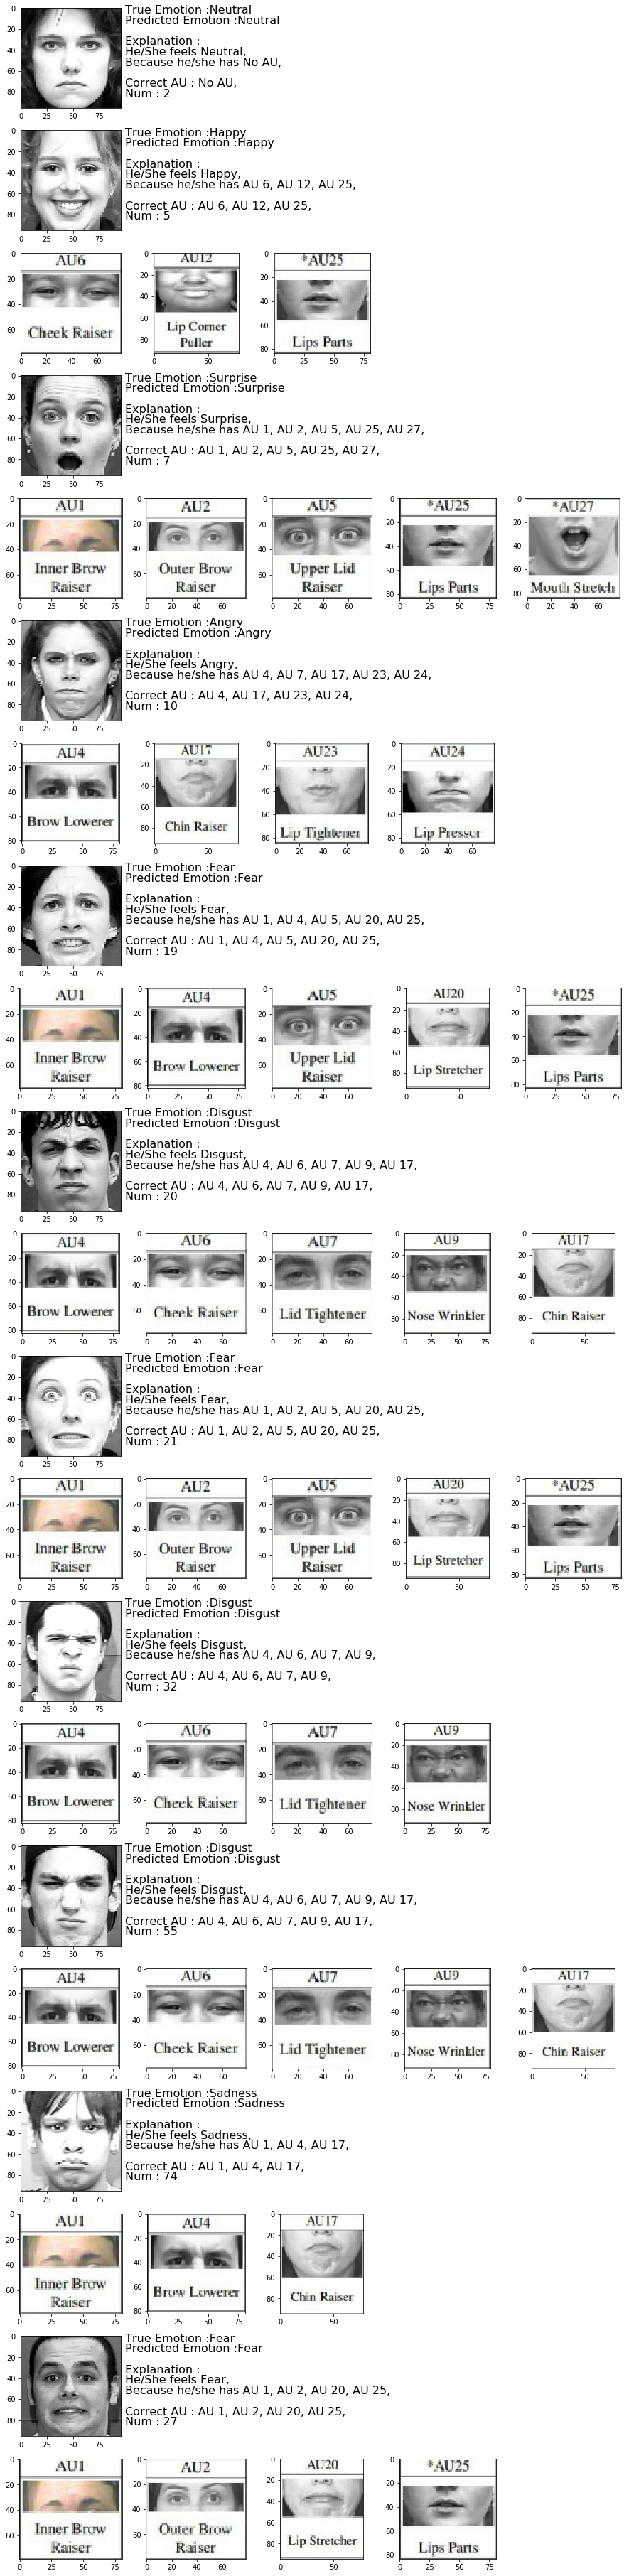

In [76]:
c = 1
data_indices = [2,5,7,10,19,20,21,32,55,74,27]
num_data = len(data_indices)
plt.figure(figsize=(15,num_data*5))
for a in data_indices:
    ax = plt.subplot(num_data*2+1,6,c)
    c = plot_prediction(ax, a, c)

plt.savefig('justification_result.png')

In [51]:
facs_acc_percent = facs_accuracy.applymap(lambda x : x /262*100)

In [52]:
facs_acc_percent = facs_acc_percent.T

In [53]:
facs_acc_percent.columns = ['Accuracy']

In [54]:
facs_pred_df = pd.DataFrame(facs_pred_np, columns=facs.columns)

In [55]:
facs_test_arranged = facs_test.astype(np.int)
facs_test_arranged.index = range(facs_test_arranged.shape[0])

In [56]:
from sklearn.metrics import f1_score
facs_f1_score = {}
for code_num in facs_pred_df.columns:    
    facs_f1_score[int(code_num)] = f1_score(facs_test_arranged[code_num], facs_pred_df[code_num])

In [57]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
facs_precision = {}
for code_num in facs_pred_df.columns:    
    facs_precision[int(code_num)] = precision_score(facs_test_arranged[code_num], facs_pred_df[code_num])

facs_precision = pd.DataFrame(facs_precision, index=['precision'])

facs_precision = facs_precision.T

facs_acc_percent['Precision'] = facs_precision['precision'].map(lambda x : x * 100)

In [58]:
facs_f1_score = pd.DataFrame(facs_f1_score, index=['f1_score'])

facs_f1_score = facs_f1_score.T

facs_acc_percent['f1_score'] = facs_f1_score['f1_score'].map(lambda x : x * 100)

In [59]:
facs_recall = {}
for code_num in facs_pred_df.columns:    
    facs_recall[int(code_num)] = recall_score(facs_test_arranged[code_num], facs_pred_df[code_num])

facs_recall = pd.DataFrame(facs_recall, index=['recall'])

facs_recall = facs_recall.T

facs_acc_percent['Recall'] = facs_recall['recall'].map(lambda x : x * 100)

In [60]:
facs_acc_percent

,Accuracy,Precision,f1_score,Recall
0,94.656489,87.323944,89.855072,92.537313
1,95.801527,98.717949,93.333333,88.505747
2,96.183206,95.161290,92.187500,89.393939
4,96.946565,97.058824,94.285714,91.666667
5,95.419847,91.525424,90.000000,88.524590
6,96.946565,95.918367,92.156863,88.679245
7,95.801527,89.189189,85.714286,82.500000
9,99.236641,100.000000,96.153846,92.592593
12,98.473282,100.000000,95.555556,91.489362
15,94.656489,100.000000,53.333333,36.363636


In [62]:
from sklearn.metrics import confusion_matrix

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

AU  0
[[186   9]
 [  5  62]]
AU  1
[[174   1]
 [ 10  77]]
AU  2
[[193   3]
 [  7  59]]
AU  4
[[188   2]
 [  6  66]]
AU  5
[[196   5]
 [  7  54]]
AU  6
[[207   2]
 [  6  47]]
AU  7
[[218   4]
 [  7  33]]
AU  9
[[235   0]
 [  2  25]]
AU  12
[[215   0]
 [  4  43]]
AU  15
[[240   0]
 [ 14   8]]
AU  17
[[195   5]
 [  6  56]]
AU  20
[[244   0]
 [  2  16]]
AU  23
[[231   4]
 [  5  22]]
AU  24
[[233   2]
 [  6  21]]
AU  25
[[148   1]
 [  2 111]]
AU  27
[[212   1]
 [  3  46]]


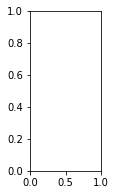

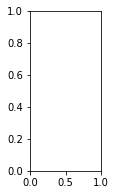

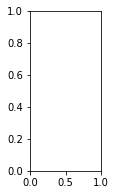

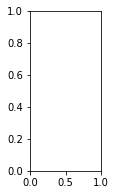

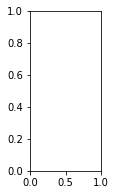

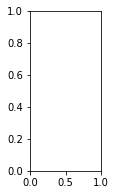

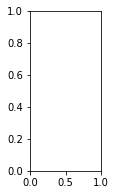

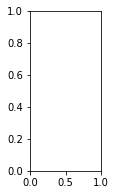

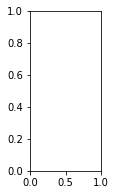

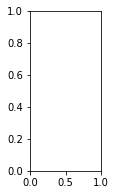

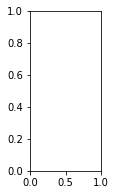

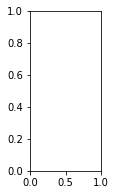

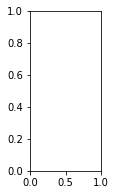

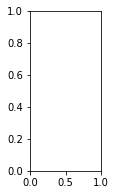

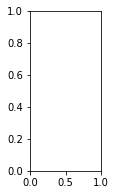

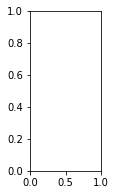

In [70]:
for index, code_num in enumerate(facs_pred_df.columns):
    plt.figure(figsize=(15,10))
    plt.subplot(3,10,index+1)

    print('AU ',code_num)
    print(confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num]))

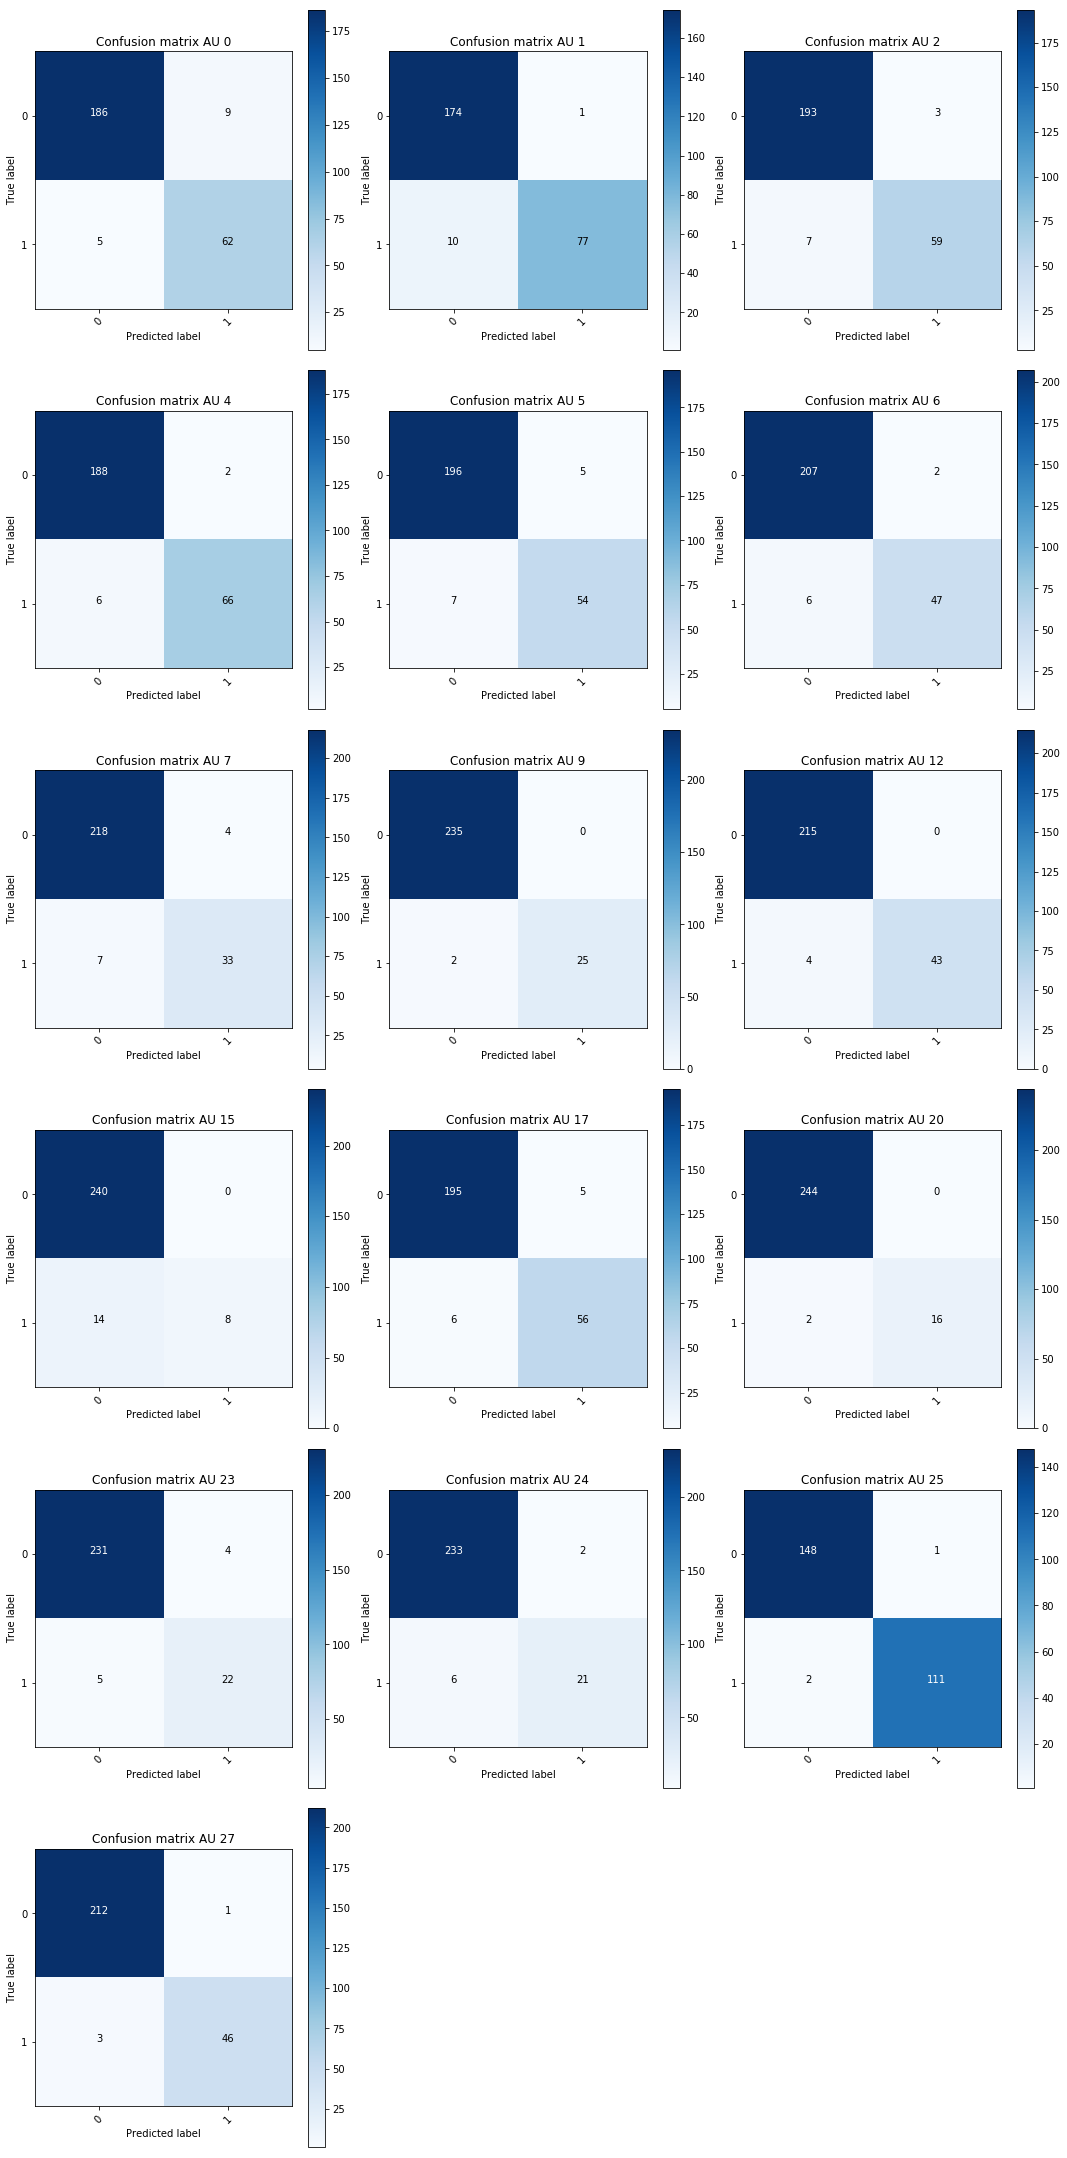

In [85]:
import itertools
class_names = [0, 1]
plt.figure(figsize=(15,50))
for index, code_num in enumerate(facs_pred_df.columns):
    plt.subplot(10,3,index+1)
    cnf_matrix = confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num])
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix AU '+str(code_num))

#     print('AU ',code_num)
#     print(confusion_matrix(facs_test_arranged[code_num], facs_pred_df[code_num]))

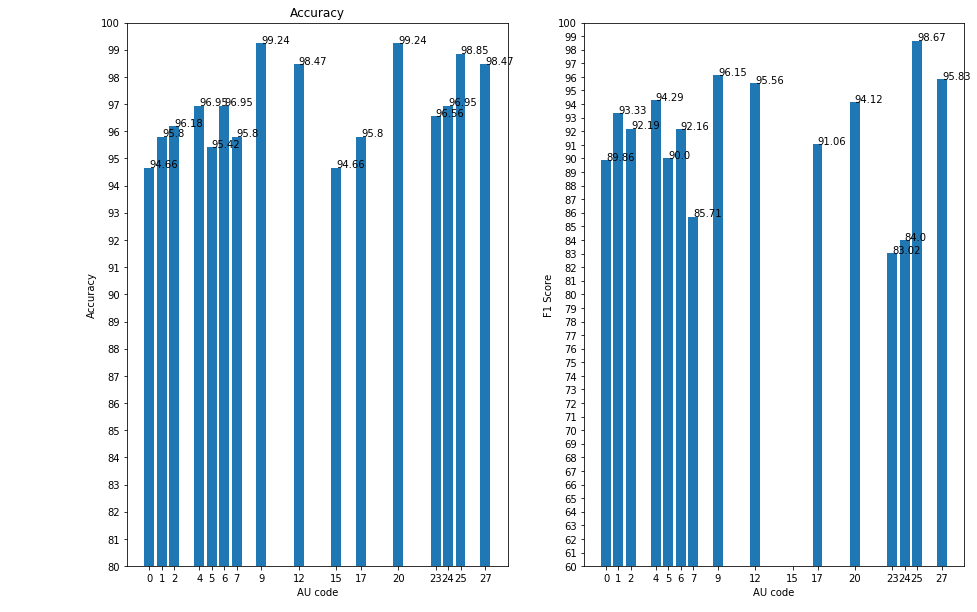

In [61]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('AU code')
plt.ylabel('Accuracy')
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['Accuracy']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))


ax = plt.subplot(1,2,2)
plt.xlabel('AU code')
plt.ylabel('F1 Score')
plt.xticks(facs_acc_percent.index)
plt.ylim((60,100))
plt.yticks(np.arange(60,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['f1_score'])
for i,j in zip(list(facs_acc_percent.index), facs_acc_percent['f1_score']):
    j = round(j, 2)
    ax.annotate(str(j),xy=(i,j))

In [213]:
facs_acc_percent.to_csv('result/feature_au_acc.csv')

<Container object of 18 artists>

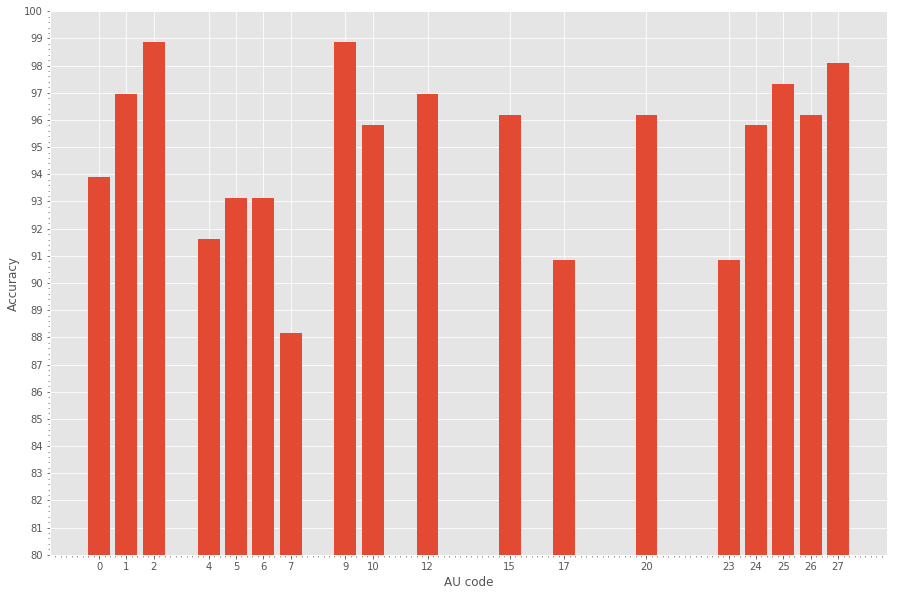

In [128]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
plt.ylabel('Accuracy')
plt.xlabel('AU code')
plt.minorticks_on()
plt.xticks(facs_acc_percent.index)
plt.ylim((80,100))
plt.yticks(np.arange(80,101,1))
plt.bar(list(facs_acc_percent.index), facs_acc_percent['Accuracy'])

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rfc = RandomForestClassifier()

In [59]:
rfc.fit(feature_train, facs_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
facs_pred = rfc.predict(feature_test)

In [67]:
facs_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [69]:
facs_test.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [75]:
correct = {}
for inst in range(facs_pred.shape[0]):
    for elem in range(facs_pred.shape[1]):
        if not elem in correct:
            correct[elem] = 0
        if facs_pred[inst][elem] == facs_test.values[inst][elem] and facs_pred[inst][elem] == 1:
            correct[elem] += 1
print(list(map(lambda x : x / facs_pred.shape[0], correct)))

[0.0, 0.003816793893129771, 0.007633587786259542, 0.011450381679389313, 0.015267175572519083, 0.019083969465648856, 0.022900763358778626, 0.026717557251908396, 0.030534351145038167, 0.03435114503816794, 0.03816793893129771, 0.04198473282442748, 0.04580152671755725, 0.04961832061068702, 0.05343511450381679, 0.05725190839694656, 0.061068702290076333, 0.0648854961832061]


## (300,)

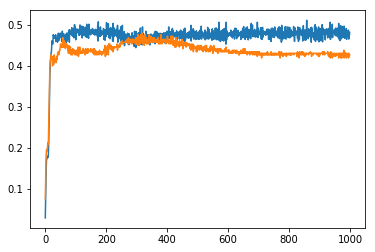

In [49]:
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000,)

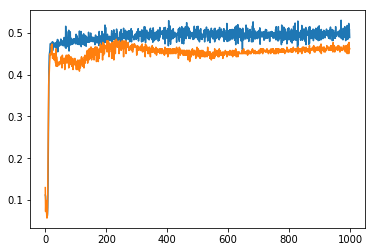

In [53]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000, 500)

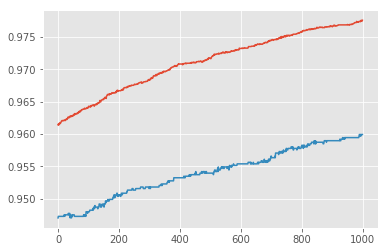

In [165]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

In [87]:
dense_model.predict(feature_test)

array([[2.18512014e-01, 5.77167809e-01, 7.63536572e-01, ...,
        5.63504756e-04, 9.23508763e-01, 2.13441402e-02],
       [9.82221782e-01, 1.37626287e-02, 2.53648125e-03, ...,
        3.66364897e-04, 1.48531352e-03, 6.00163010e-04],
       [8.52516592e-01, 7.67027810e-02, 1.06651649e-01, ...,
        5.03868284e-03, 1.97427981e-02, 5.98940812e-03],
       ...,
       [2.41851970e-03, 9.72193539e-01, 7.29454577e-01, ...,
        3.35017825e-03, 9.85902429e-01, 8.27229023e-03],
       [6.59153843e-03, 9.47243035e-01, 9.97439861e-01, ...,
        1.01467536e-04, 9.98487234e-01, 9.05066609e-01],
       [9.98491168e-01, 1.74474262e-03, 4.95835033e-04, ...,
        3.89486714e-03, 1.03251274e-04, 4.89191807e-05]], dtype=float32)